# Terphenyl Heteropolymer Analysis Notebook

In this notebook I will perform several data analysis on the RHH terphenyl octamer. This molecule has 3 aromatic moieties connected with peptide-linkers. Collaborators in the Gellman group, at U Wisc-Ma., have been trying to synthesize and characterize this molecule. This would represent a novel type of foldamer molecule.

## Replica Exchange Energy Distributions

For replica exchange data, it is imporant to see the overlap of energy states from each replica. For this reason we will look at the histogram of energies from each simulation and confirm that energies each replica is behaving as expected.

In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import panedr
import matplotlib.pyplot as plt
import numpy as np
import os
import pymbar
import mdtraj
import heat_capacity
import itertools
from scipy.constants import physical_constants, find
import tqdm
import plotting
import h_bonds
from multiprocessing import Pool

plt.style.use('ggplot')

In [3]:
energy_df = panedr.edr_to_df("/mnt/summit/simulations/octamer_Rchiral/RHH/remd_sim/200K_to_350K/sim0/npt.edr")
energy_df.head()

Time         Bond         Angle  Proper Dih.       LJ-14   Coulomb-14  \
0.0      0.0  3476.319336  14484.898438   473.606232  600.466797 -1050.351562   
100.0  100.0  3502.831055  14487.014648   550.683533  594.352966 -1065.079834   
200.0  200.0  3316.188477  14587.367188   554.614258  607.232178 -1044.868652   
300.0  300.0  3395.050049  14413.551758   444.376282  583.858276 -1040.240723   
400.0  400.0  3492.964355  14485.119141   485.414673  610.842896 -1047.402832   

            LJ (SR)  Disper. corr.  Coulomb (SR)  Coul. recip.  ...  \
0.0      477.176941     -29.210785  -5453.289551   1227.846069  ...   
100.0 -11282.683594     -20.597462  -5019.292969    717.184265  ...   
200.0 -11487.283203     -20.709114  -4963.344238    730.007263  ...   
300.0 -11402.691406     -20.525780  -4969.524902    758.597900  ...   
400.0 -11158.217773     -20.684299  -5043.535156    759.867371  ...   

          Pres-YZ     Pres-ZX     Pres-ZY     Pres-ZZ  #Surf*SurfTen  \
0.0    -59.740219  -66.604286  -59.739651 -341.236633   -2889.187744   
100.0   -7.894585  351.736206   -7.891168   22.695278    -489.800720   
200.0  292.284241  182.889084  292.283508 -419.383118   -3540.321045   
300.0   42.175716   43.144127   42.173859  -63.384182    1830.393188   
400.0   67.564667  541.294800   67.562790  719.336487    3305.005371   

       Box-Vel-XX  Box-Vel-YY  Box-Vel-ZZ    T-System  Lamb-System  
0.0      0.000000    0.000000    0.000000  200.326340          1.0  
100.0   -0.000146   -0.000146   -0.000146  203.144241          1.0  
200.0    0.001262    0.001262    0.001262  198.623581          1.0  
300.0    0.002638    0.002638    0.002638  197.848648          1.0  
400.0    0.003554    0.003554    0.003554  200.015839          1.0  

[5 rows x 50 columns]

In [4]:
# Extract Potential Energies from each simulation
sim_dir_name = "sim"
path = "/mnt/summit/simulations/octamer_Rchiral/RHH/remd_sim/200K_to_350K/"
n_replicas = 40

energies, temps = heat_capacity.get_energies(sim_dir_name, path, n_replicas)

npt.edr
npt.part0002.edr
npt.part0003.edr
npt.part0004.edr
npt.edr
npt.part0002.edr
npt.part0003.edr
npt.part0004.edr
npt.edr
npt.part0002.edr
npt.part0003.edr
npt.part0004.edr
npt.edr
npt.part0002.edr
npt.part0003.edr
npt.part0004.edr
npt.edr
npt.part0002.edr
npt.part0003.edr
npt.part0004.edr
npt.edr
npt.part0002.edr
npt.part0003.edr
npt.part0004.edr
npt.edr
npt.part0002.edr
npt.part0003.edr
npt.part0004.edr
npt.edr
npt.part0002.edr
npt.part0003.edr
npt.part0004.edr
npt.edr
npt.part0002.edr
npt.part0003.edr
npt.part0004.edr
npt.edr
npt.part0002.edr
npt.part0003.edr
npt.part0004.edr
npt.edr
npt.part0002.edr
npt.part0003.edr
npt.part0004.edr
npt.edr
npt.part0002.edr
npt.part0003.edr
npt.part0004.edr
npt.edr
npt.part0002.edr
npt.part0003.edr
npt.part0004.edr
npt.edr
npt.part0002.edr
npt.part0003.edr
npt.part0004.edr
npt.edr
npt.part0002.edr
npt.part0003.edr
npt.part0004.edr
npt.edr
npt.part0002.edr
npt.part0003.edr
npt.part0004.edr
npt.edr
npt.part0002.edr
npt.part0003.edr
npt.part0004.e

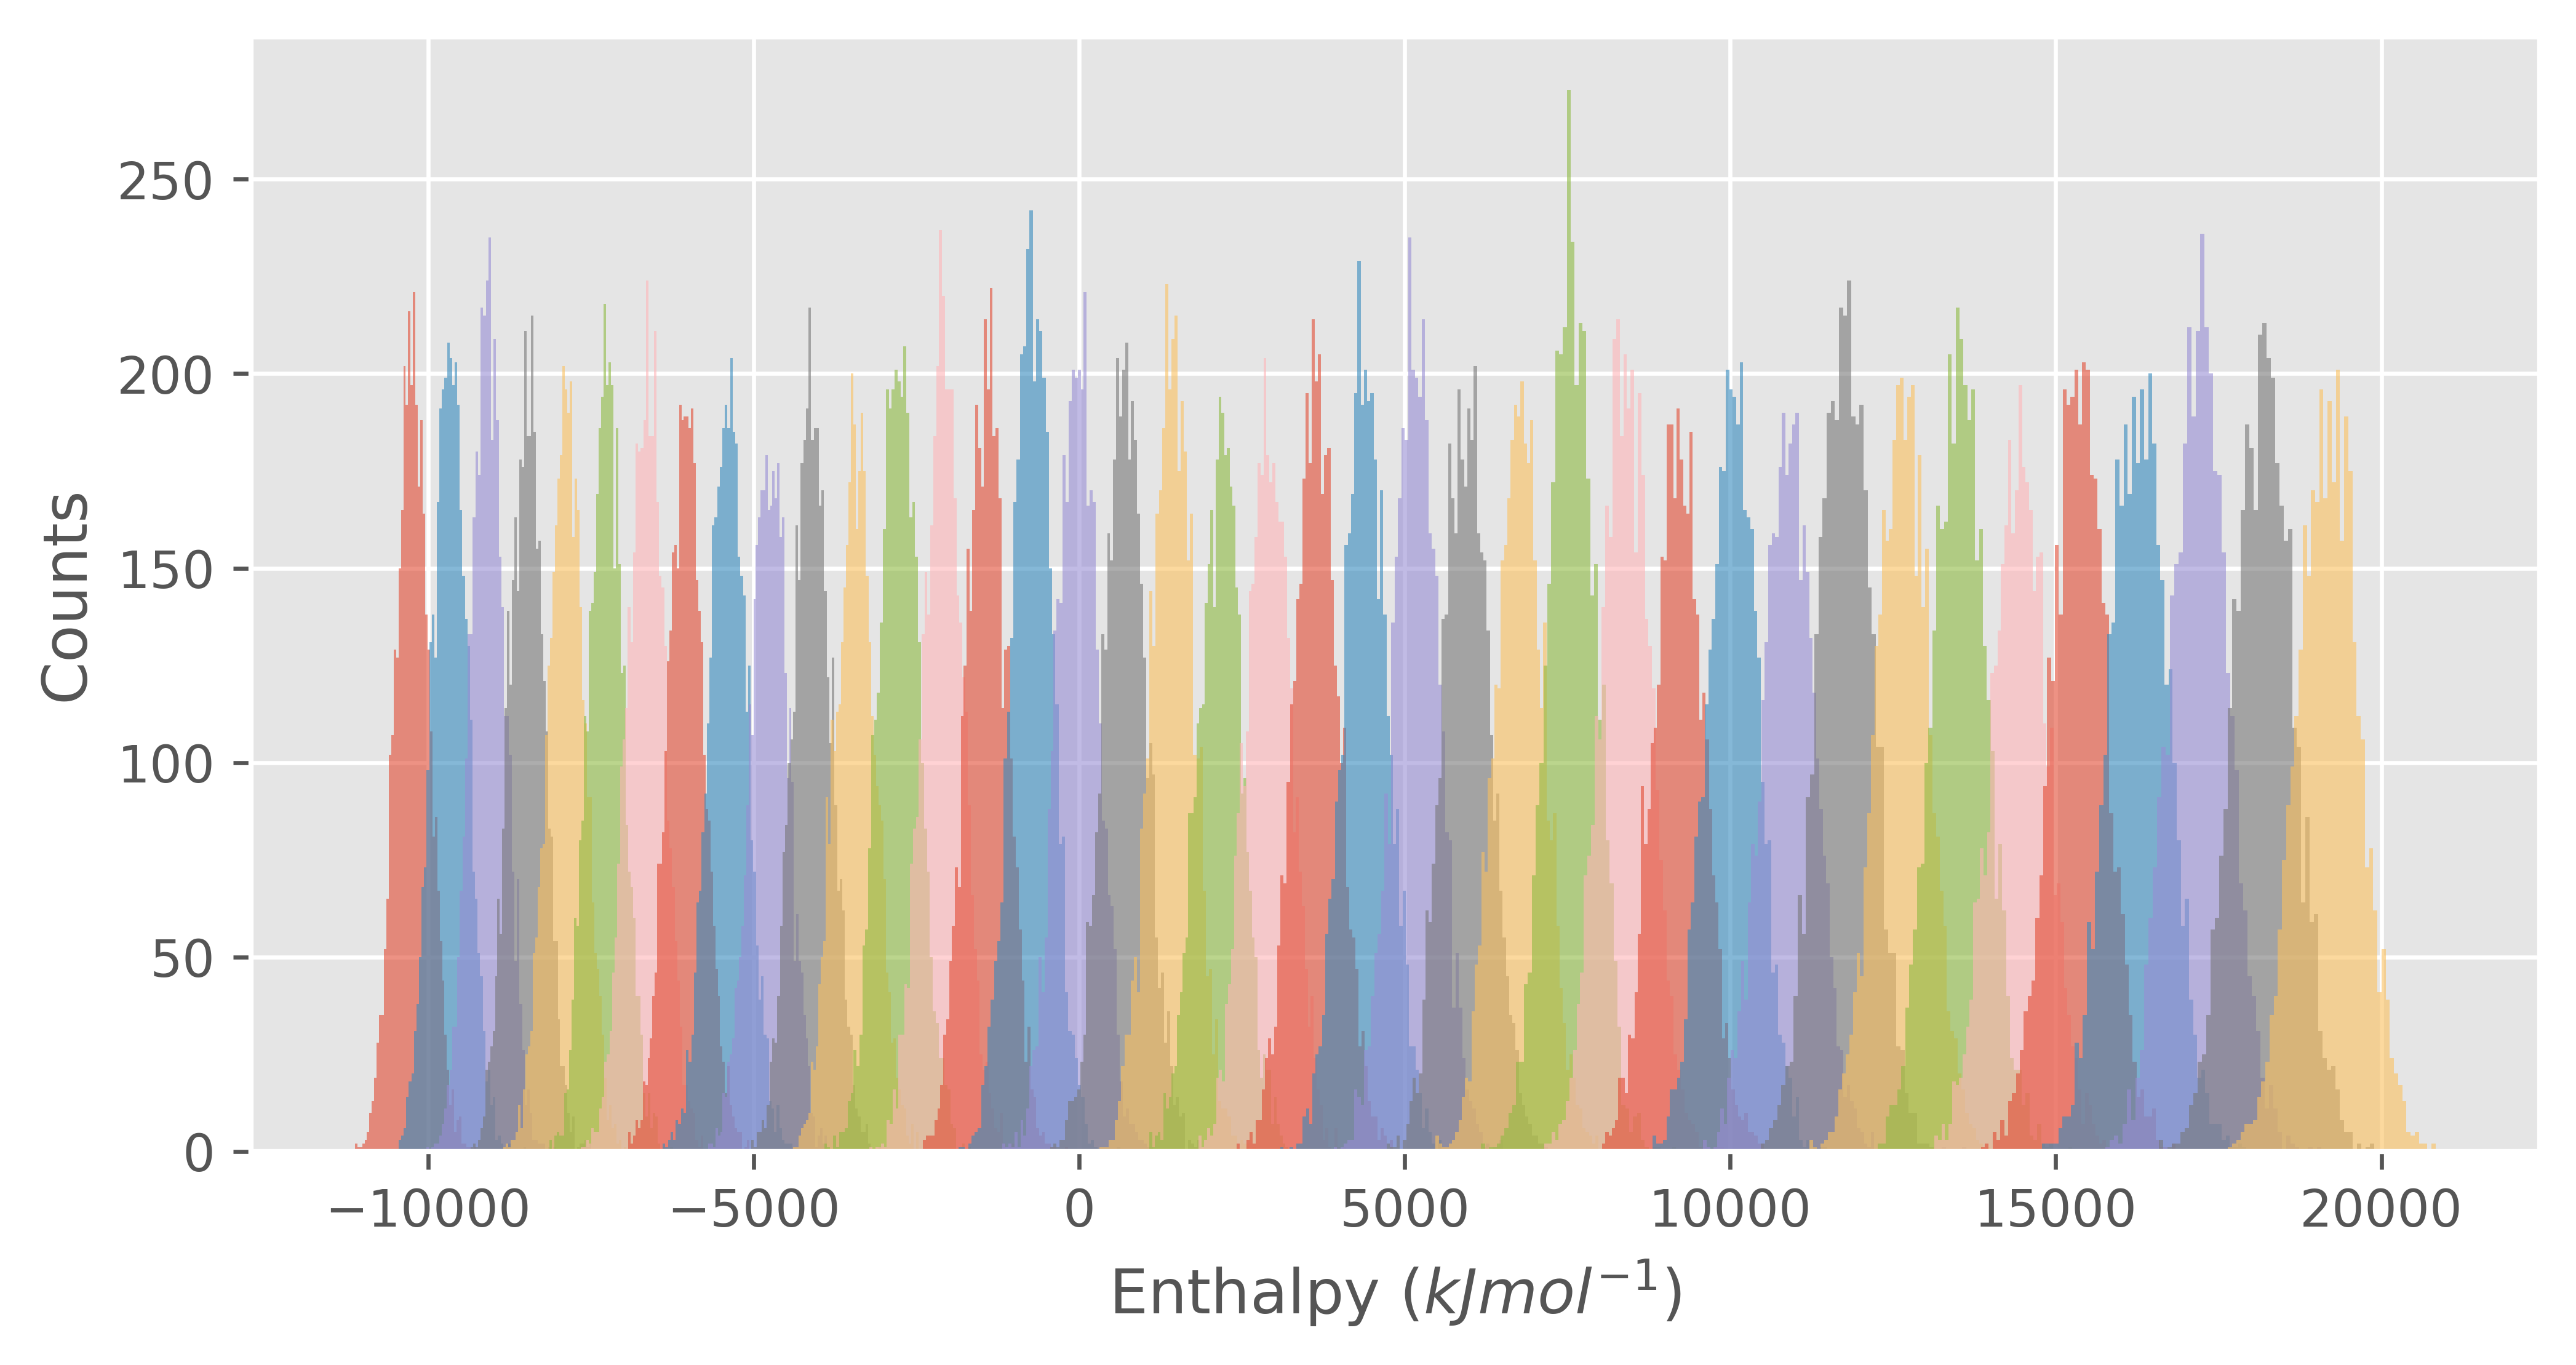

In [5]:
plotting.plot_RE_energy_distributions(energies)

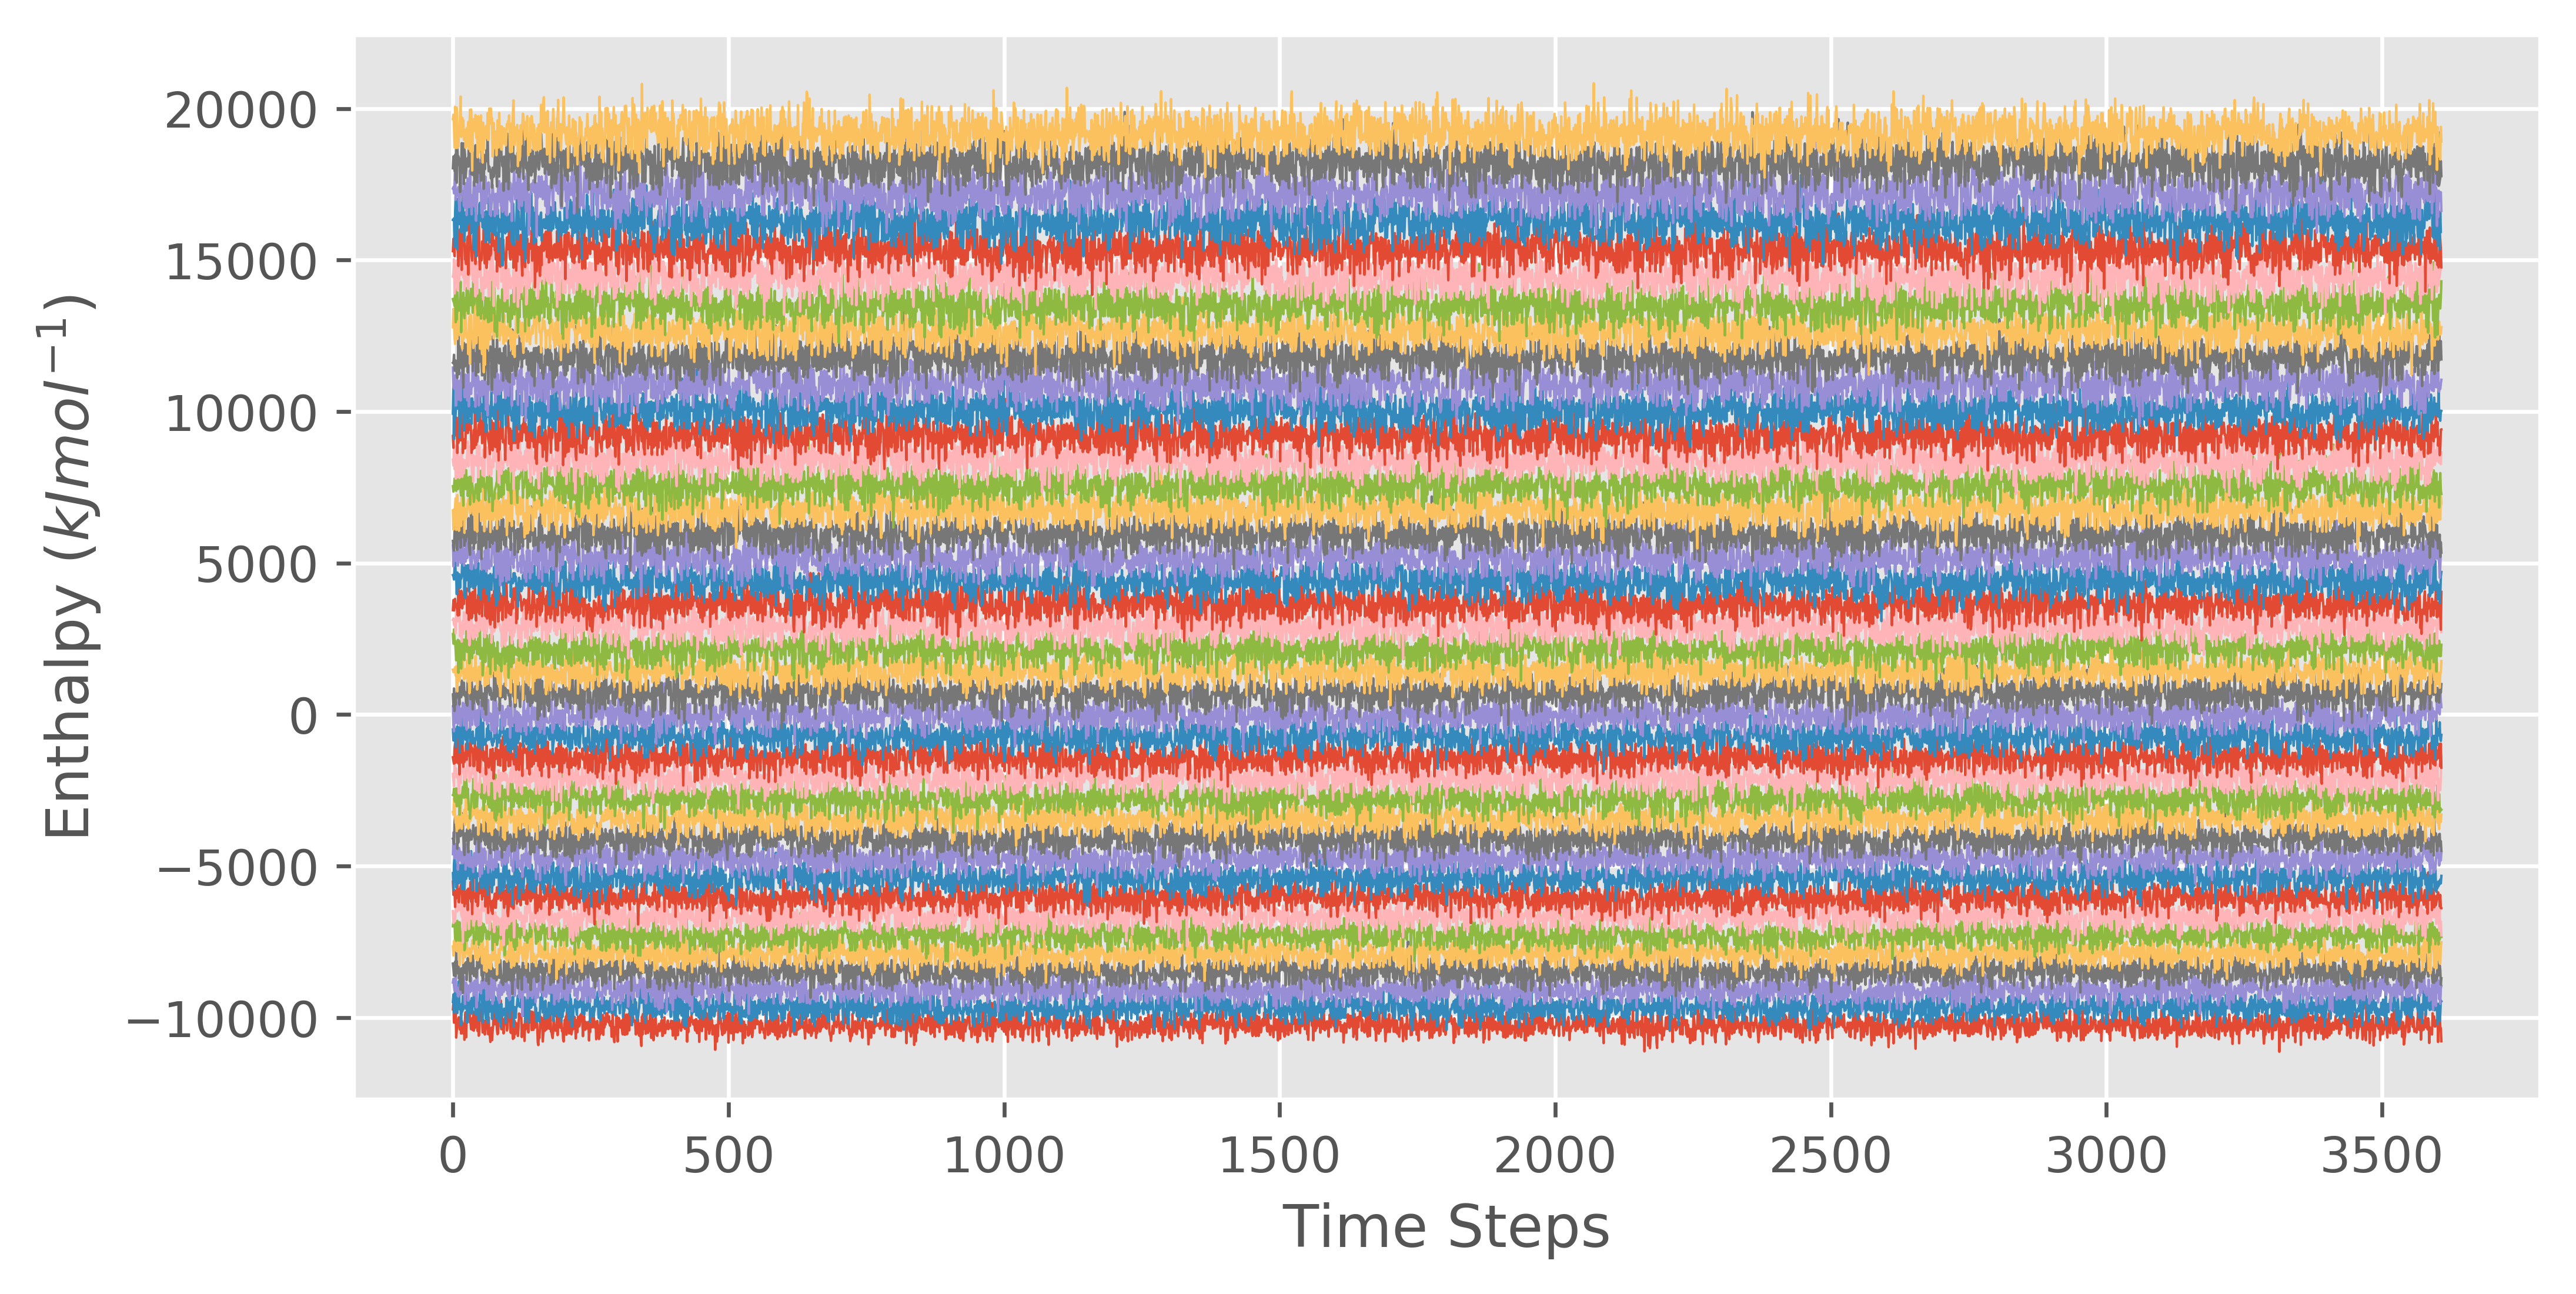

In [6]:
plotting.plot_RE_energy_trajectory(energies)

## Heat Capacity Curve

The nice thing about replica exchange simulations is we can compute the change of a systems heat capacity with temperature.This is especially useful for systems that experience large surface area changes during phase transistions, such as protein folding or melting transitions.

We'll be implementing heat capacity equation, using enthalpy:

$$C_p = \frac{d<H>}{dT}$$

We'll be calculating expectation heat capacities using the following formulas:



In [7]:
u_kln, n_samples, t_list, betas = heat_capacity.construct_u_kln_matrix(temps, energies, add_temps = np.linspace(200, 350, 200))

In [8]:
# MBAR
mbar = pymbar.MBAR(u_kln, n_samples, verbose = True, relative_tolerance = 1e-10, initial_f_k= None, maximum_iterations=1000)

K (total states) = 240, total samples = 144397

They are therefore likely to to be the same thermodynamic state.  This can occasionally cause
numerical problems with computing the covariance of their energy difference, which must be
identically zero in any case. Consider combining them into a single state.


They are therefore likely to to be the same thermodynamic state.  This can occasionally cause
numerical problems with computing the covariance of their energy difference, which must be
identically zero in any case. Consider combining them into a single state.

N_k = 
[3610 3610 3610 3610 3610 3610 3610 3610 3610 3610 3610 3610 3610 3610
 3610 3610 3610 3610 3610 3610 3610 3610 3610 3609 3610 3610 3610 3610
 3610 3610 3610 3610 3610 3610 3609 3610 3609 3610 3610 3610    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0  

In [64]:
# Building potential energy kln matrix
E_kln = u_kln
for k in range(u_kln.shape[1]):
    E_kln[:,k,:] *= betas[k]**(-1)

# mean and variance of energy
results = mbar.computeExpectations(E_kln, state_dependent=True, return_dict=True)
E_expected = results['mu']
dE_expected = results['sigma']

In [65]:
# mean and variance of difference of energies
results = mbar.computeExpectations(E_kln, output='differences', state_dependent=True, return_dict=True)
DeltaE_expected = results['mu']
dDeltaE_expected = results['sigma']

In [66]:
# mean and variance of energies squared
results = mbar.computeExpectations(E_kln**2, state_dependent=True, return_dict=True)
E2_expected = results['mu']
dE2_expected = results['sigma']

In [67]:
kb = physical_constants["Boltzmann constant"][0] *  physical_constants["Avogadro constant"][0] / 1000 # J (molK)^-1

Cp_expect = (E2_expected - (E_expected*E_expected)) / (kb * t_list**2)

In [68]:
Cp_expect = heat_capacity.calculate_cp(mbar, E_kln, t_list)

Text(0.5, 0, 'Temperature (K)')

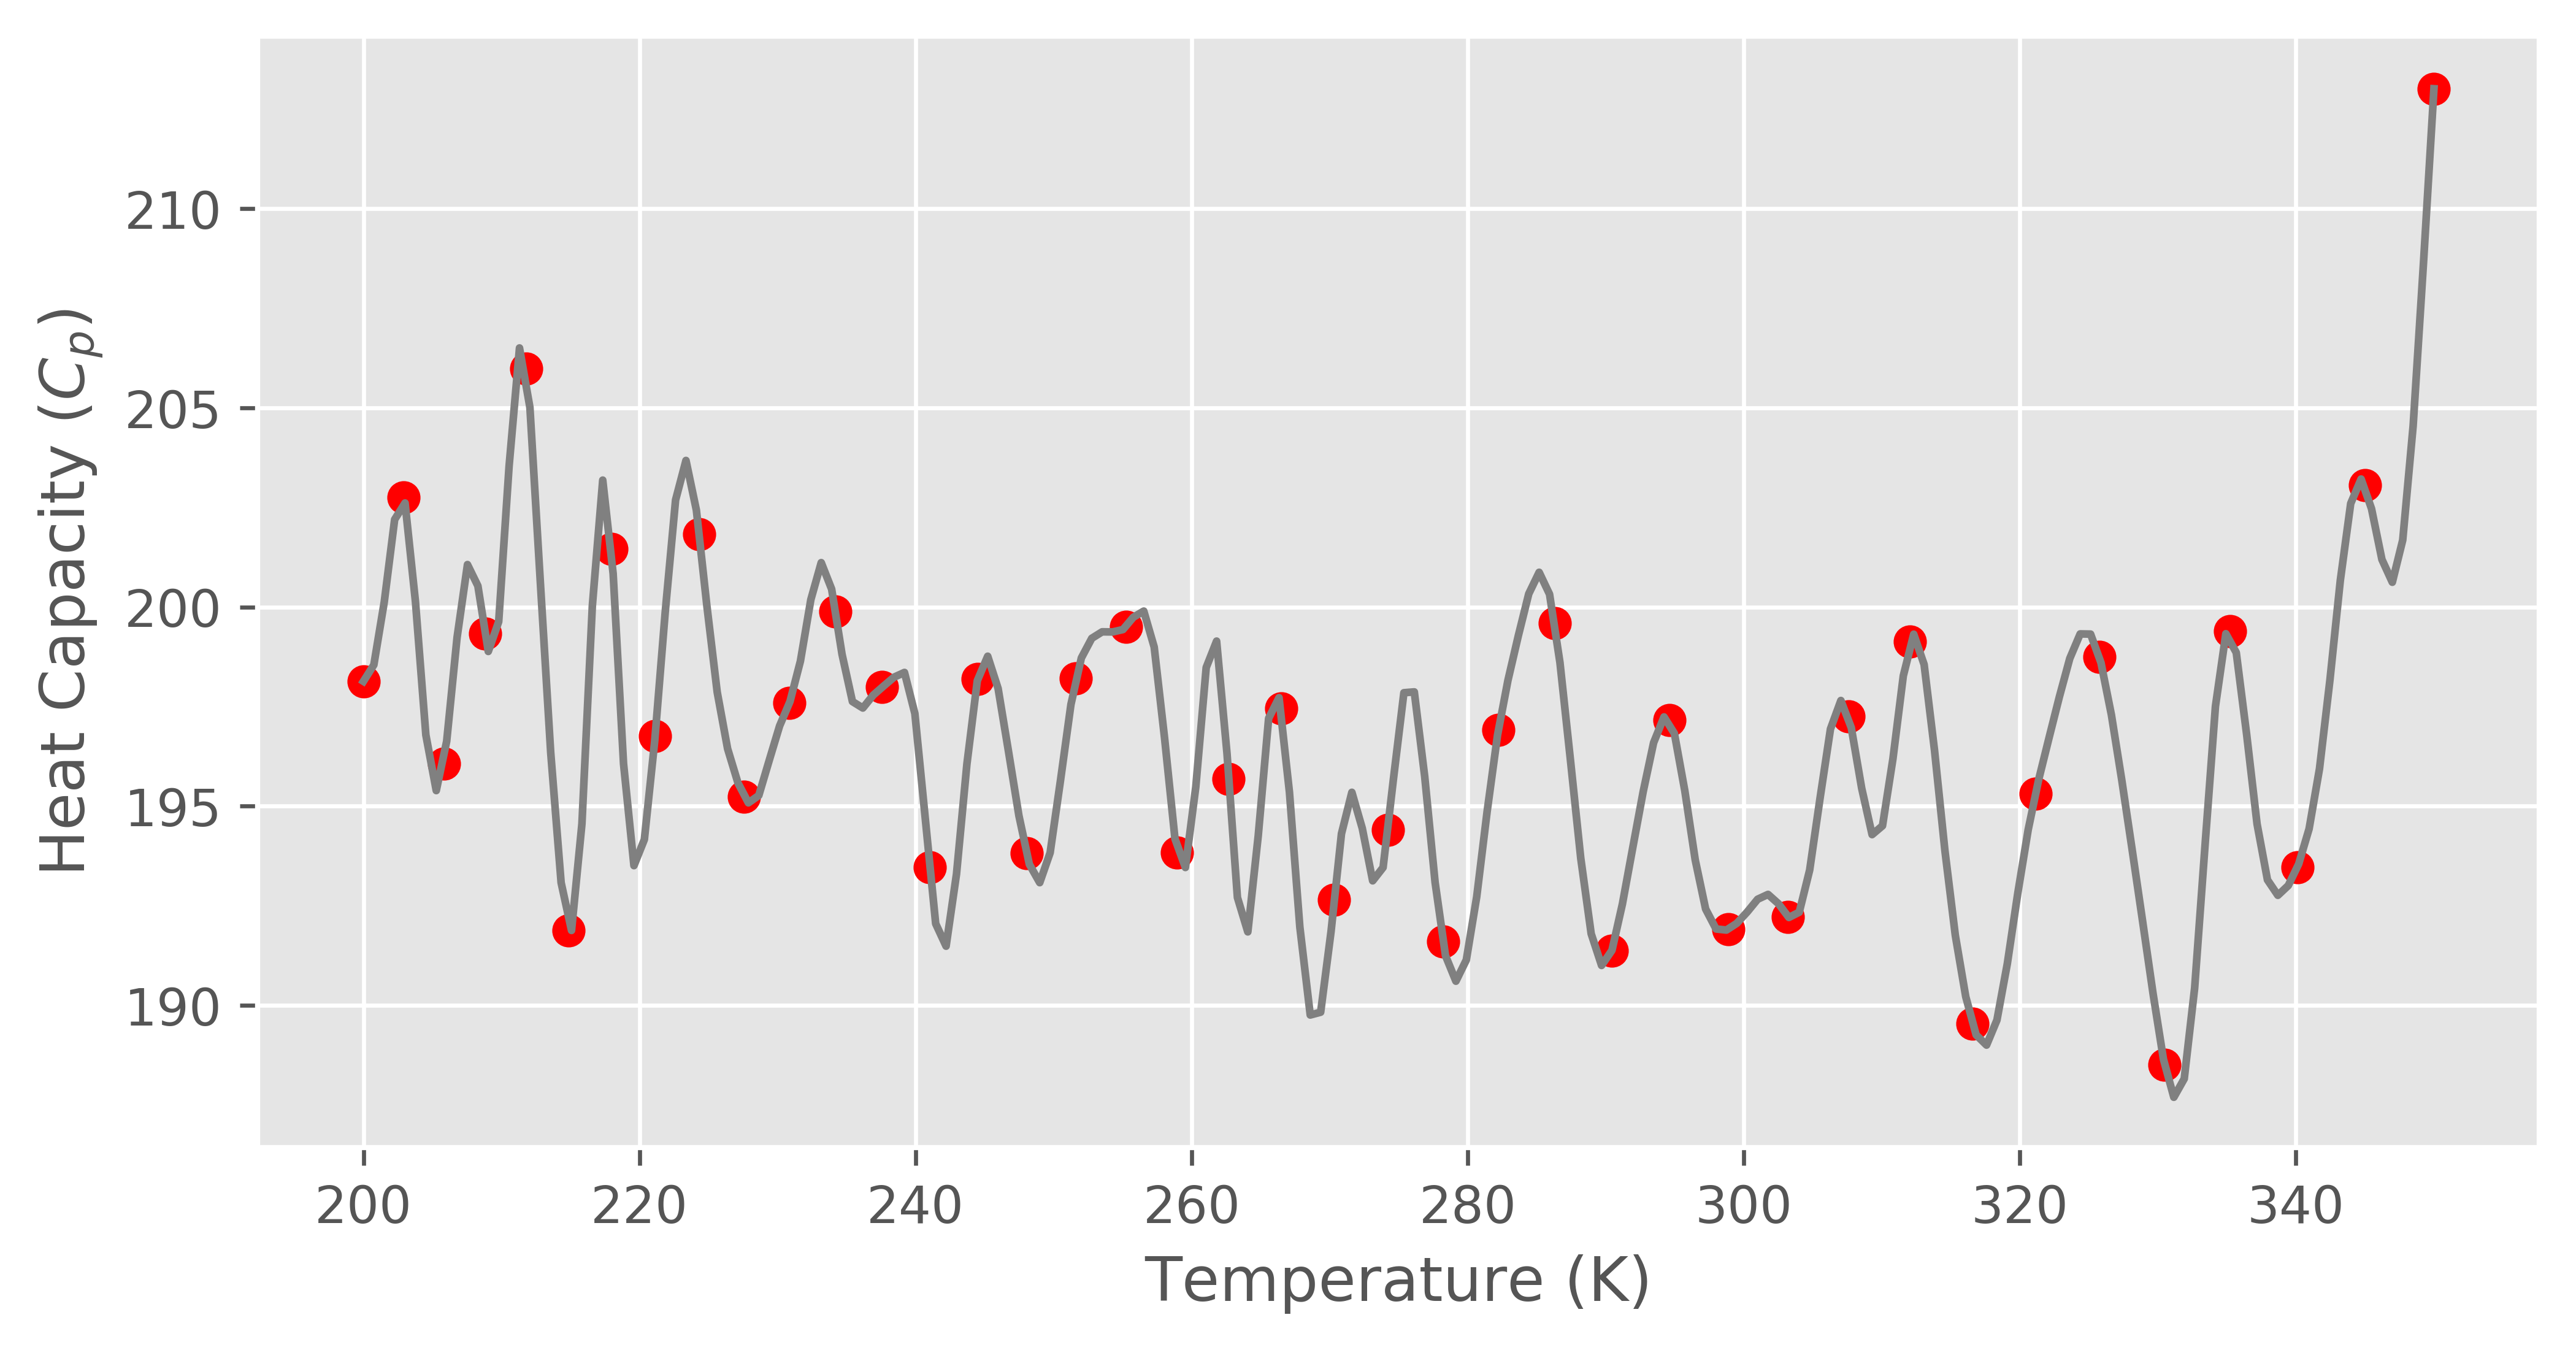

In [69]:
plt.figure(figsize=[8,4], dpi=600)
plt.plot(t_list[40:], Cp_expect[40:], color = "gray")
plt.scatter(t_list[:40], Cp_expect[:40], color = "red")
plt.ylabel("Heat Capacity ($C_p$)")
plt.xlabel("Temperature (K)")

## Bootstrapping Cp Results

We can use bootstrapping to generate uncertainties in our data set.

In [15]:
# Attempted to multiprocess the MBAR Bootstrapping
# But it appears that the optimizations in pymbar parallelize to use all processors
# Or the single process of mbar is extremely memory intensive

def cp_bootstrap(j):
    print("Working on bootstrap", j,"...")
    t1 = time.time()
    energies_boot = []
    for i in range(len(energies)):
        energies_boot.append(np.random.choice(energies[i], size=len(energies[i])))
    # Solve MBAR equations
    u_kln_boot, n_samples_boot, t_list_boot, betas_boot = heat_capacity.construct_u_kln_matrix(temps, energies_boot, add_temps = np.linspace(200, 350, 200))
    mbar_boot = pymbar.MBAR(u_kln_boot, n_samples_boot, verbose = False, relative_tolerance = 1e-10, initial_f_k= None, maximum_iterations=1000)
    # Compute expectations and variance of relevant terms
    E_kln_boot = u_kln_boot
    for k in range(u_kln_boot.shape[1]):
        E_kln_boot[:,k,:] *= betas_boot[k]**(-1)
    Cp_boot = heat_capacity.calculate_cp(mbar_boot, E_kln_boot, t_list)
    # compute boot strap cp
    t2 = time.time()
    print("bootstraj", j, "took", t2-t1, "seconds")
    return(Cp_boot)
    

In [16]:
from multiprocessing import Pool
import time

N_boots = 100
pool = Pool(1)

cp_boot = pool.map(cp_bootstrap, range(N_boots))

Working on bootstrap 0 ...
A squared uncertainty is negative. Largest Magnitude = 0.000000


/home/lenny/anaconda3/envs/terphenyl/lib/python3.8/site-packages/pymbar/mbar.py:1593: RuntimeWarning: invalid value encountered in sqrt
  return np.sqrt(np.array(d2))


bootstraj 0 took 25.18971300125122 seconds
Working on bootstrap 1 ...
bootstraj 1 took 23.893100023269653 seconds
Working on bootstrap 2 ...
bootstraj 2 took 23.835205793380737 seconds
Working on bootstrap 3 ...
bootstraj 3 took  23.951051235198975seconds
Working on bootstrap 4 ...
A squared uncertainty is negative. Largest Magnitude = 0.000000


/home/lenny/anaconda3/envs/terphenyl/lib/python3.8/site-packages/pymbar/mbar.py:1593: RuntimeWarning: invalid value encountered in sqrt
  return np.sqrt(np.array(d2))


bootstraj 4 took 23.96561884880066 seconds
Working on bootstrap 5 ...
bootstraj 5 took 23.886784076690674 seconds
Working on bootstrap 6 ...
A squared uncertainty is negative. Largest Magnitude = 0.000000


/home/lenny/anaconda3/envs/terphenyl/lib/python3.8/site-packages/pymbar/mbar.py:1593: RuntimeWarning: invalid value encountered in sqrt
  return np.sqrt(np.array(d2))


bootstraj 6 took 23.673920154571533 seconds
Working on bootstrap 7 ...
bootstraj 7 took 24.304459810256958 seconds
Working on bootstrap 8 ...
A squared uncertainty is negative. Largest Magnitude = 0.000000


/home/lenny/anaconda3/envs/terphenyl/lib/python3.8/site-packages/pymbar/mbar.py:1593: RuntimeWarning: invalid value encountered in sqrt
  return np.sqrt(np.array(d2))


bootstraj 8 took 23.9013249874115 seconds
Working on bootstrap 9 ...
A squared uncertainty is negative. Largest Magnitude = 0.000000


/home/lenny/anaconda3/envs/terphenyl/lib/python3.8/site-packages/pymbar/mbar.py:1593: RuntimeWarning: invalid value encountered in sqrt
  return np.sqrt(np.array(d2))


bootstraj 9 took 23.826993227005005 seconds
Working on bootstrap 10 ...
A squared uncertainty is negative. Largest Magnitude = 0.000000


/home/lenny/anaconda3/envs/terphenyl/lib/python3.8/site-packages/pymbar/mbar.py:1593: RuntimeWarning: invalid value encountered in sqrt
  return np.sqrt(np.array(d2))


bootstraj 10 took 23.923823356628418 seconds
Working on bootstrap 11 ...
bootstraj 11 took 23.87777042388916 seconds
Working on bootstrap 12 ...
bootstraj 12 took 24.006194829940796 seconds
Working on bootstrap 13 ...
bootstraj 13 took 24.74104642868042 seconds
Working on bootstrap 14 ...
bootstraj 14 took 23.657864093780518 seconds
Working on bootstrap 15 ...
bootstraj 15 took 22.71667242050171 seconds
Working on bootstrap 16 ...
A squared uncertainty is negative. Largest Magnitude = 0.000000


/home/lenny/anaconda3/envs/terphenyl/lib/python3.8/site-packages/pymbar/mbar.py:1593: RuntimeWarning: invalid value encountered in sqrt
  return np.sqrt(np.array(d2))


bootstraj 16 took 22.956825017929077 seconds
Working on bootstrap 17 ...
bootstraj 17 took 22.3940646648407 seconds
Working on bootstrap 18 ...
bootstraj 18 took 22.56093406677246 seconds
Working on bootstrap 19 ...
bootstraj 19 took 22.406484365463257 seconds
Working on bootstrap 20 ...
A squared uncertainty is negative. Largest Magnitude = 0.000000


/home/lenny/anaconda3/envs/terphenyl/lib/python3.8/site-packages/pymbar/mbar.py:1593: RuntimeWarning: invalid value encountered in sqrt
  return np.sqrt(np.array(d2))


bootstraj 20 took 22.723809719085693 seconds
Working on bootstrap 21 ...
A squared uncertainty is negative. Largest Magnitude = 0.000000


/home/lenny/anaconda3/envs/terphenyl/lib/python3.8/site-packages/pymbar/mbar.py:1593: RuntimeWarning: invalid value encountered in sqrt
  return np.sqrt(np.array(d2))


bootstraj 21 took 22.42428731918335 seconds
Working on bootstrap 22 ...
bootstraj 22 took 22.31049919128418 seconds
Working on bootstrap 23 ...
bootstraj 23 took 22.677725076675415 seconds
Working on bootstrap 24 ...
A squared uncertainty is negative. Largest Magnitude = 0.000000


/home/lenny/anaconda3/envs/terphenyl/lib/python3.8/site-packages/pymbar/mbar.py:1593: RuntimeWarning: invalid value encountered in sqrt
  return np.sqrt(np.array(d2))


bootstraj 24 took 22.384013175964355 seconds
Working on bootstrap 25 ...
bootstraj 25 took 22.374627351760864 seconds
Working on bootstrap 26 ...
A squared uncertainty is negative. Largest Magnitude = 0.000000


/home/lenny/anaconda3/envs/terphenyl/lib/python3.8/site-packages/pymbar/mbar.py:1593: RuntimeWarning: invalid value encountered in sqrt
  return np.sqrt(np.array(d2))


bootstraj 26 took 22.723816394805908 seconds
Working on bootstrap 27 ...
bootstraj 27 took 22.40033483505249 seconds
Working on bootstrap 28 ...
A squared uncertainty is negative. Largest Magnitude = 0.000000


/home/lenny/anaconda3/envs/terphenyl/lib/python3.8/site-packages/pymbar/mbar.py:1593: RuntimeWarning: invalid value encountered in sqrt
  return np.sqrt(np.array(d2))


bootstraj 28 took 22.467165231704712 seconds
Working on bootstrap 29 ...
bootstraj 29 took 22.404948472976685 seconds
Working on bootstrap 30 ...
A squared uncertainty is negative. Largest Magnitude = 0.000000


/home/lenny/anaconda3/envs/terphenyl/lib/python3.8/site-packages/pymbar/mbar.py:1593: RuntimeWarning: invalid value encountered in sqrt
  return np.sqrt(np.array(d2))


bootstraj 30 took 22.34093737602234 seconds
Working on bootstrap 31 ...
bootstraj 31 took 22.36054039001465 seconds
Working on bootstrap 32 ...
bootstraj 32 took 22.848353385925293 seconds
Working on bootstrap 33 ...
A squared uncertainty is negative. Largest Magnitude = 0.000000


/home/lenny/anaconda3/envs/terphenyl/lib/python3.8/site-packages/pymbar/mbar.py:1593: RuntimeWarning: invalid value encountered in sqrt
  return np.sqrt(np.array(d2))


bootstraj 33 took 22.830523014068604 seconds
Working on bootstrap 34 ...
bootstraj 34 took 22.592806100845337 seconds
Working on bootstrap 35 ...
A squared uncertainty is negative. Largest Magnitude = 0.000000


/home/lenny/anaconda3/envs/terphenyl/lib/python3.8/site-packages/pymbar/mbar.py:1593: RuntimeWarning: invalid value encountered in sqrt
  return np.sqrt(np.array(d2))


bootstraj 35 took 22.752825021743774 seconds
Working on bootstrap 36 ...
bootstraj 36 took 22.897956132888794 seconds
Working on bootstrap 37 ...
bootstraj 37 took 22.55829954147339 seconds
Working on bootstrap 38 ...
A squared uncertainty is negative. Largest Magnitude = 0.000000


/home/lenny/anaconda3/envs/terphenyl/lib/python3.8/site-packages/pymbar/mbar.py:1593: RuntimeWarning: invalid value encountered in sqrt
  return np.sqrt(np.array(d2))


bootstraj 38 took 24.0083487033844 seconds
Working on bootstrap 39 ...
bootstraj 39 took 22.911093711853027 seconds
Working on bootstrap 40 ...
A squared uncertainty is negative. Largest Magnitude = 0.000000


/home/lenny/anaconda3/envs/terphenyl/lib/python3.8/site-packages/pymbar/mbar.py:1593: RuntimeWarning: invalid value encountered in sqrt
  return np.sqrt(np.array(d2))


bootstraj 40 took 22.66069221496582 seconds
Working on bootstrap 41 ...
bootstraj 41 took 22.655064821243286 seconds
Working on bootstrap 42 ...
bootstraj 42 took 22.482905864715576 seconds
Working on bootstrap 43 ...
A squared uncertainty is negative. Largest Magnitude = 0.000000


/home/lenny/anaconda3/envs/terphenyl/lib/python3.8/site-packages/pymbar/mbar.py:1593: RuntimeWarning: invalid value encountered in sqrt
  return np.sqrt(np.array(d2))


bootstraj 43 took 22.53970432281494 seconds
Working on bootstrap 44 ...
A squared uncertainty is negative. Largest Magnitude = 0.000000


/home/lenny/anaconda3/envs/terphenyl/lib/python3.8/site-packages/pymbar/mbar.py:1593: RuntimeWarning: invalid value encountered in sqrt
  return np.sqrt(np.array(d2))


bootstraj 44 took 22.59120202064514 seconds
Working on bootstrap 45 ...
A squared uncertainty is negative. Largest Magnitude = 0.000000


/home/lenny/anaconda3/envs/terphenyl/lib/python3.8/site-packages/pymbar/mbar.py:1593: RuntimeWarning: invalid value encountered in sqrt
  return np.sqrt(np.array(d2))


bootstraj 45 took 22.985644340515137 seconds
Working on bootstrap 46 ...
bootstraj 46 took 22.52533984184265 seconds
Working on bootstrap 47 ...
bootstraj 47 took 22.89257025718689 seconds
Working on bootstrap 48 ...
bootstraj 48 took 22.123655080795288 seconds
Working on bootstrap 49 ...
A squared uncertainty is negative. Largest Magnitude = 0.000000


/home/lenny/anaconda3/envs/terphenyl/lib/python3.8/site-packages/pymbar/mbar.py:1593: RuntimeWarning: invalid value encountered in sqrt
  return np.sqrt(np.array(d2))


bootstraj 49 took 22.598717212677002 seconds
Working on bootstrap 50 ...
A squared uncertainty is negative. Largest Magnitude = 0.000000


/home/lenny/anaconda3/envs/terphenyl/lib/python3.8/site-packages/pymbar/mbar.py:1593: RuntimeWarning: invalid value encountered in sqrt
  return np.sqrt(np.array(d2))


bootstraj 50 took 22.68408465385437 seconds
Working on bootstrap 51 ...
A squared uncertainty is negative. Largest Magnitude = 0.000000


/home/lenny/anaconda3/envs/terphenyl/lib/python3.8/site-packages/pymbar/mbar.py:1593: RuntimeWarning: invalid value encountered in sqrt
  return np.sqrt(np.array(d2))


bootstraj 51 took 22.58114242553711 seconds
Working on bootstrap 52 ...
A squared uncertainty is negative. Largest Magnitude = 0.000000


/home/lenny/anaconda3/envs/terphenyl/lib/python3.8/site-packages/pymbar/mbar.py:1593: RuntimeWarning: invalid value encountered in sqrt
  return np.sqrt(np.array(d2))


bootstraj 52 took 23.54398775100708 seconds
Working on bootstrap 53 ...
bootstraj 53 took 22.577701330184937 seconds
Working on bootstrap 54 ...
A squared uncertainty is negative. Largest Magnitude = 0.000000


/home/lenny/anaconda3/envs/terphenyl/lib/python3.8/site-packages/pymbar/mbar.py:1593: RuntimeWarning: invalid value encountered in sqrt
  return np.sqrt(np.array(d2))


bootstraj 54 took 22.489794731140137 seconds
Working on bootstrap 55 ...
bootstraj 55 took 22.743637800216675 seconds
Working on bootstrap 56 ...
bootstraj 56 took 22.470328092575073 seconds
Working on bootstrap 57 ...
A squared uncertainty is negative. Largest Magnitude = 0.000000


/home/lenny/anaconda3/envs/terphenyl/lib/python3.8/site-packages/pymbar/mbar.py:1593: RuntimeWarning: invalid value encountered in sqrt
  return np.sqrt(np.array(d2))


bootstraj 57 took 22.49560523033142 seconds
Working on bootstrap 58 ...
A squared uncertainty is negative. Largest Magnitude = 0.000000


/home/lenny/anaconda3/envs/terphenyl/lib/python3.8/site-packages/pymbar/mbar.py:1593: RuntimeWarning: invalid value encountered in sqrt
  return np.sqrt(np.array(d2))


bootstraj 58 took 24.18416976928711 seconds
Working on bootstrap 59 ...
A squared uncertainty is negative. Largest Magnitude = 0.000000


/home/lenny/anaconda3/envs/terphenyl/lib/python3.8/site-packages/pymbar/mbar.py:1593: RuntimeWarning: invalid value encountered in sqrt
  return np.sqrt(np.array(d2))


bootstraj 59 took 23.358091831207275 seconds
Working on bootstrap 60 ...
A squared uncertainty is negative. Largest Magnitude = 0.000000


/home/lenny/anaconda3/envs/terphenyl/lib/python3.8/site-packages/pymbar/mbar.py:1593: RuntimeWarning: invalid value encountered in sqrt
  return np.sqrt(np.array(d2))


bootstraj 60 took 23.092740297317505 seconds
Working on bootstrap 61 ...
A squared uncertainty is negative. Largest Magnitude = 0.000000


/home/lenny/anaconda3/envs/terphenyl/lib/python3.8/site-packages/pymbar/mbar.py:1593: RuntimeWarning: invalid value encountered in sqrt
  return np.sqrt(np.array(d2))


bootstraj 61 took 23.520636558532715 seconds
Working on bootstrap 62 ...
bootstraj 62 took 23.568866968154907 seconds
Working on bootstrap 63 ...
A squared uncertainty is negative. Largest Magnitude = 0.000000


/home/lenny/anaconda3/envs/terphenyl/lib/python3.8/site-packages/pymbar/mbar.py:1593: RuntimeWarning: invalid value encountered in sqrt
  return np.sqrt(np.array(d2))


bootstraj 63 took 23.053784370422363 seconds
Working on bootstrap 64 ...
A squared uncertainty is negative. Largest Magnitude = 0.000000


/home/lenny/anaconda3/envs/terphenyl/lib/python3.8/site-packages/pymbar/mbar.py:1593: RuntimeWarning: invalid value encountered in sqrt
  return np.sqrt(np.array(d2))


bootstraj 64 took 23.25021982192993 seconds
Working on bootstrap 65 ...
A squared uncertainty is negative. Largest Magnitude = 0.000000


/home/lenny/anaconda3/envs/terphenyl/lib/python3.8/site-packages/pymbar/mbar.py:1593: RuntimeWarning: invalid value encountered in sqrt
  return np.sqrt(np.array(d2))


bootstraj 65 took 23.3094220161438 seconds
Working on bootstrap 66 ...
A squared uncertainty is negative. Largest Magnitude = 0.000000


/home/lenny/anaconda3/envs/terphenyl/lib/python3.8/site-packages/pymbar/mbar.py:1593: RuntimeWarning: invalid value encountered in sqrt
  return np.sqrt(np.array(d2))


bootstraj 66 took 23.331262588500977 seconds
Working on bootstrap 67 ...
bootstraj 67 took 23.13082194328308 seconds
Working on bootstrap 68 ...
bootstraj 68 took 22.040077686309814 seconds
Working on bootstrap 69 ...
A squared uncertainty is negative. Largest Magnitude = 0.000000


/home/lenny/anaconda3/envs/terphenyl/lib/python3.8/site-packages/pymbar/mbar.py:1593: RuntimeWarning: invalid value encountered in sqrt
  return np.sqrt(np.array(d2))


bootstraj 69 took 22.006654262542725 seconds
Working on bootstrap 70 ...
bootstraj 70 took 22.105671644210815 seconds
Working on bootstrap 71 ...
A squared uncertainty is negative. Largest Magnitude = 0.000000


/home/lenny/anaconda3/envs/terphenyl/lib/python3.8/site-packages/pymbar/mbar.py:1593: RuntimeWarning: invalid value encountered in sqrt
  return np.sqrt(np.array(d2))


bootstraj 71 took 21.901342153549194 seconds
Working on bootstrap 72 ...
bootstraj 72 took 21.95182514190674 seconds
Working on bootstrap 73 ...
A squared uncertainty is negative. Largest Magnitude = 0.000000


/home/lenny/anaconda3/envs/terphenyl/lib/python3.8/site-packages/pymbar/mbar.py:1593: RuntimeWarning: invalid value encountered in sqrt
  return np.sqrt(np.array(d2))


bootstraj 73 took 21.899409294128418 seconds
Working on bootstrap 74 ...
A squared uncertainty is negative. Largest Magnitude = 0.000000


/home/lenny/anaconda3/envs/terphenyl/lib/python3.8/site-packages/pymbar/mbar.py:1593: RuntimeWarning: invalid value encountered in sqrt
  return np.sqrt(np.array(d2))


bootstraj 74 took 21.982096195220947 seconds
Working on bootstrap 75 ...
A squared uncertainty is negative. Largest Magnitude = 0.000000


/home/lenny/anaconda3/envs/terphenyl/lib/python3.8/site-packages/pymbar/mbar.py:1593: RuntimeWarning: invalid value encountered in sqrt
  return np.sqrt(np.array(d2))


bootstraj 75 took 22.270208835601807 seconds
Working on bootstrap 76 ...
A squared uncertainty is negative. Largest Magnitude = 0.000000


/home/lenny/anaconda3/envs/terphenyl/lib/python3.8/site-packages/pymbar/mbar.py:1593: RuntimeWarning: invalid value encountered in sqrt
  return np.sqrt(np.array(d2))


bootstraj 76 took 22.88337278366089 seconds
Working on bootstrap 77 ...
A squared uncertainty is negative. Largest Magnitude = 0.000000


/home/lenny/anaconda3/envs/terphenyl/lib/python3.8/site-packages/pymbar/mbar.py:1593: RuntimeWarning: invalid value encountered in sqrt
  return np.sqrt(np.array(d2))


bootstraj 77 took 23.568476915359497 seconds
Working on bootstrap 78 ...
A squared uncertainty is negative. Largest Magnitude = 0.000000


/home/lenny/anaconda3/envs/terphenyl/lib/python3.8/site-packages/pymbar/mbar.py:1593: RuntimeWarning: invalid value encountered in sqrt
  return np.sqrt(np.array(d2))


bootstraj 78 took 22.889661073684692 seconds
Working on bootstrap 79 ...
bootstraj 79 took 23.51844096183777 seconds
Working on bootstrap 80 ...
A squared uncertainty is negative. Largest Magnitude = 0.000000


/home/lenny/anaconda3/envs/terphenyl/lib/python3.8/site-packages/pymbar/mbar.py:1593: RuntimeWarning: invalid value encountered in sqrt
  return np.sqrt(np.array(d2))


bootstraj 80 took 23.23887062072754 seconds
Working on bootstrap 81 ...
A squared uncertainty is negative. Largest Magnitude = 0.000000


/home/lenny/anaconda3/envs/terphenyl/lib/python3.8/site-packages/pymbar/mbar.py:1593: RuntimeWarning: invalid value encountered in sqrt
  return np.sqrt(np.array(d2))


bootstraj 81 took 23.91667914390564 seconds
Working on bootstrap 82 ...
A squared uncertainty is negative. Largest Magnitude = 0.000000


/home/lenny/anaconda3/envs/terphenyl/lib/python3.8/site-packages/pymbar/mbar.py:1593: RuntimeWarning: invalid value encountered in sqrt
  return np.sqrt(np.array(d2))


bootstraj 82 took 23.14921283721924 seconds
Working on bootstrap 83 ...
bootstraj 83 took 23.177180767059326 seconds
Working on bootstrap 84 ...
bootstraj 84 took 23.40499711036682 seconds
Working on bootstrap 85 ...
A squared uncertainty is negative. Largest Magnitude = 0.000000


/home/lenny/anaconda3/envs/terphenyl/lib/python3.8/site-packages/pymbar/mbar.py:1593: RuntimeWarning: invalid value encountered in sqrt
  return np.sqrt(np.array(d2))


bootstraj 85 took 23.253955602645874 seconds
Working on bootstrap 86 ...
bootstraj 86 took 23.510955810546875 seconds
Working on bootstrap 87 ...
A squared uncertainty is negative. Largest Magnitude = 0.000000


/home/lenny/anaconda3/envs/terphenyl/lib/python3.8/site-packages/pymbar/mbar.py:1593: RuntimeWarning: invalid value encountered in sqrt
  return np.sqrt(np.array(d2))


bootstraj 87 took 23.335031747817993 seconds
Working on bootstrap 88 ...
A squared uncertainty is negative. Largest Magnitude = 0.000000


/home/lenny/anaconda3/envs/terphenyl/lib/python3.8/site-packages/pymbar/mbar.py:1593: RuntimeWarning: invalid value encountered in sqrt
  return np.sqrt(np.array(d2))


bootstraj 88 took 23.150181770324707 seconds
Working on bootstrap 89 ...
bootstraj 89 took 23.225192546844482 seconds
Working on bootstrap 90 ...
A squared uncertainty is negative. Largest Magnitude = 0.000000


/home/lenny/anaconda3/envs/terphenyl/lib/python3.8/site-packages/pymbar/mbar.py:1593: RuntimeWarning: invalid value encountered in sqrt
  return np.sqrt(np.array(d2))


bootstraj 90 took 23.42471933364868 seconds
Working on bootstrap 91 ...
bootstraj 91 took 23.228307247161865 seconds
Working on bootstrap 92 ...
bootstraj 92 took 23.460726499557495 seconds
Working on bootstrap 93 ...
A squared uncertainty is negative. Largest Magnitude = 0.000000


/home/lenny/anaconda3/envs/terphenyl/lib/python3.8/site-packages/pymbar/mbar.py:1593: RuntimeWarning: invalid value encountered in sqrt
  return np.sqrt(np.array(d2))


bootstraj 93 took 23.270686388015747 seconds
Working on bootstrap 94 ...
A squared uncertainty is negative. Largest Magnitude = 0.000000


/home/lenny/anaconda3/envs/terphenyl/lib/python3.8/site-packages/pymbar/mbar.py:1593: RuntimeWarning: invalid value encountered in sqrt
  return np.sqrt(np.array(d2))


bootstraj 94 took 23.36562466621399 seconds
Working on bootstrap 95 ...
A squared uncertainty is negative. Largest Magnitude = 0.000000


/home/lenny/anaconda3/envs/terphenyl/lib/python3.8/site-packages/pymbar/mbar.py:1593: RuntimeWarning: invalid value encountered in sqrt
  return np.sqrt(np.array(d2))


bootstraj 95 took 22.892255783081055 seconds
Working on bootstrap 96 ...
A squared uncertainty is negative. Largest Magnitude = 0.000000


/home/lenny/anaconda3/envs/terphenyl/lib/python3.8/site-packages/pymbar/mbar.py:1593: RuntimeWarning: invalid value encountered in sqrt
  return np.sqrt(np.array(d2))


bootstraj 96 took 23.21520447731018 seconds
Working on bootstrap 97 ...
A squared uncertainty is negative. Largest Magnitude = 0.000000


/home/lenny/anaconda3/envs/terphenyl/lib/python3.8/site-packages/pymbar/mbar.py:1593: RuntimeWarning: invalid value encountered in sqrt
  return np.sqrt(np.array(d2))


bootstraj 97 took 23.76867938041687 seconds
Working on bootstrap 98 ...
A squared uncertainty is negative. Largest Magnitude = 0.000000


/home/lenny/anaconda3/envs/terphenyl/lib/python3.8/site-packages/pymbar/mbar.py:1593: RuntimeWarning: invalid value encountered in sqrt
  return np.sqrt(np.array(d2))


bootstraj 98 took 23.13844323158264 seconds
Working on bootstrap 99 ...
bootstraj 99 took 22.92571520805359 seconds


In [17]:
cp_boot = np.array(cp_boot)

In [18]:
mu_cp_boot = np.mean(cp_boot, axis = 0)
sigma_cp_boot = np.std(cp_boot, axis = 0)

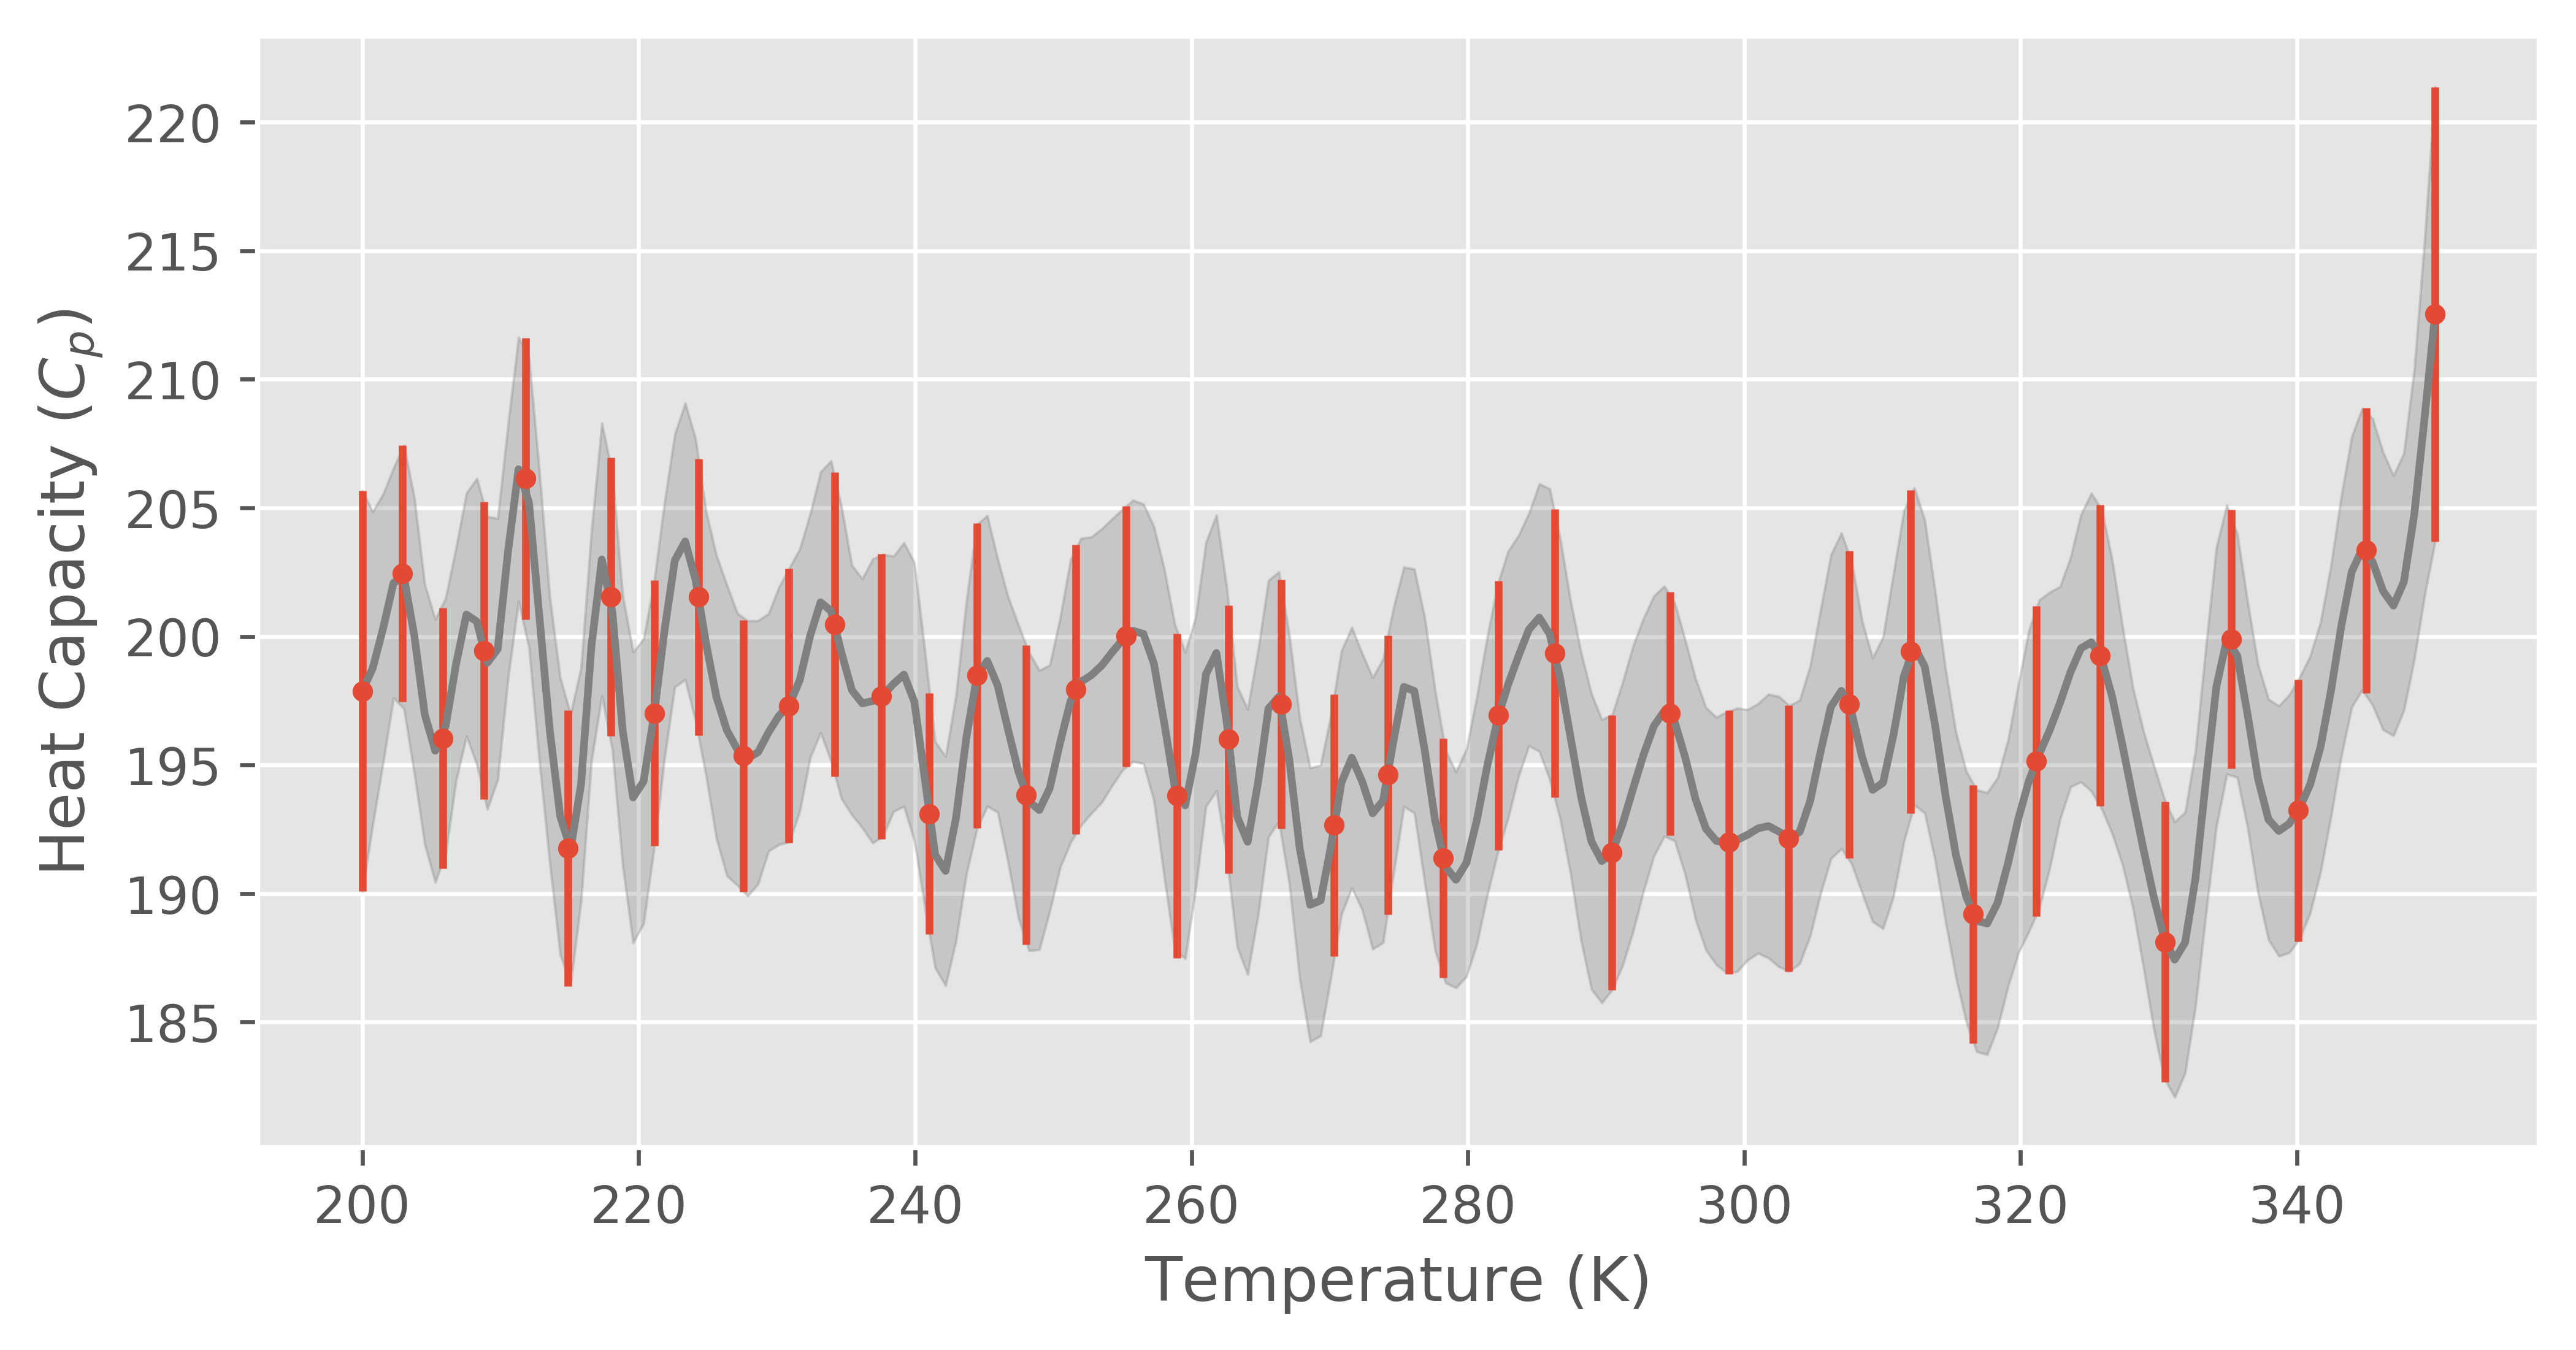

In [19]:
plotting.plot_bootstrapped_heat_capacity(mu_cp_boot, sigma_cp_boot, t_list, 40)

## H-Bonding with Temperature

Since we're unsure whether the Cp spike we're observing at 225 K is due to the solvent or the molecule, we need to investigate the average hydrogen bonds formed in each replica simulation. This will confirm if there is a significant change in the number of hydrogen bonds at low temperatures, indicating that the terphenyl molecule may be giving rise to the large heat capacity spike.

In [6]:
remd_trajs = h_bonds.REMD_trajectories("/mnt/summit/simulations/octamer_Rchiral/RHH/remd_sim/200K_to_350K", "npt", "whole.xtc","sim", "/mnt/summit/simulations/octamer_Rchiral/RHH/remd_sim/200K_to_350K/sim0/berendsen.gro", np = 1)

Replica 0
npt.whole.xtc
npt.part0002.whole.xtc
npt.part0003.whole.xtc
npt.part0004.whole.xtc
Replica 1
npt.whole.xtc
npt.part0002.whole.xtc
npt.part0003.whole.xtc
npt.part0004.whole.xtc
Replica 2
npt.whole.xtc
npt.part0002.whole.xtc
npt.part0003.whole.xtc
npt.part0004.whole.xtc
Replica 3
npt.whole.xtc
npt.part0002.whole.xtc
npt.part0003.whole.xtc
npt.part0004.whole.xtc
Replica 4
npt.whole.xtc
npt.part0002.whole.xtc
npt.part0003.whole.xtc
npt.part0004.whole.xtc
Replica 5
npt.whole.xtc
npt.part0002.whole.xtc
npt.part0003.whole.xtc
npt.part0004.whole.xtc
Replica 6
npt.whole.xtc
npt.part0002.whole.xtc
npt.part0003.whole.xtc
npt.part0004.whole.xtc
Replica 7
npt.whole.xtc
npt.part0002.whole.xtc
npt.part0003.whole.xtc
npt.part0004.whole.xtc
Replica 8
npt.whole.xtc
npt.part0002.whole.xtc
npt.part0003.whole.xtc
npt.part0004.whole.xtc
Replica 9
npt.whole.xtc
npt.part0002.whole.xtc
npt.part0003.whole.xtc
npt.part0004.whole.xtc
Replica 10
npt.whole.xtc
npt.part0002.whole.xtc
npt.part0003.whole.xtc

In [7]:
remd_trajs.trajs[0][0].top

<mdtraj.Topology with 1 chains, 1262 residues, 6678 atoms, 0 bonds at 0x7fd382298190>

In [11]:
h_bond_finder = h_bonds.HydrogenBondFinder(remd_trajs.trajs[0][0], remd_trajs.trajs[0][0].top)
h_bond_finder.get_donors()
h_bond_finder.get_acceptors()
n_h_bonds, h_bond_ids = h_bond_finder.get_hydrogen_bonds(remd_trajs.trajs[0])

100%|██████████| 3608/3608 [00:03<00:00, 1079.44it/s]


In [12]:
pool = Pool(4)

100%|██████████| 3608/3608 [00:02<00:00, 1766.07it/s]


In [13]:
n_h_bonds_remd, h_bonds_remd = zip(*pool.map(h_bond_finder.get_hydrogen_bonds, remd_trajs.trajs))

In [14]:
n_h_bonds_remd = np.array(n_h_bonds_remd)
h_bonds_remd = h_bonds_remd

In [15]:
temps = np.array(remd_trajs.temps)

Text(0.5, 0, 'Replica Temperature')

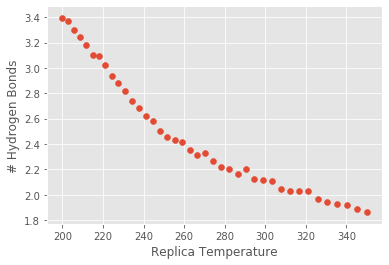

In [16]:
plt.scatter(temps, np.mean(n_h_bonds_remd, axis = 1))
plt.ylabel("# Hydrogen Bonds")
plt.xlabel("Replica Temperature")

In [17]:
n_h_bonds_remd.shape

(40, 3608)

In [18]:
n_h_bonds_remd[0]

array([7, 7, 7, ..., 4, 3, 3])

In [62]:
u_kln.shape
n_h_bonds_remd.shape

(40, 3608)

In [20]:
h_bonds_kln = np.zeros([240, 240, 3608])
for k in range(n_h_bonds_remd.shape[0]):
    for l in range(h_bonds_kln.shape[0]):
        h_bonds_kln[k,l,:] = n_h_bonds_remd[k]

In [21]:
for i in range(h_bonds_kln.shape[0]):
    print(h_bonds_kln)

[[[7. 7. 7. ... 4. 3. 3.]
  [7. 7. 7. ... 4. 3. 3.]
  [7. 7. 7. ... 4. 3. 3.]
  ...
  [7. 7. 7. ... 4. 3. 3.]
  [7. 7. 7. ... 4. 3. 3.]
  [7. 7. 7. ... 4. 3. 3.]]

 [[7. 7. 7. ... 3. 4. 4.]
  [7. 7. 7. ... 3. 4. 4.]
  [7. 7. 7. ... 3. 4. 4.]
  ...
  [7. 7. 7. ... 3. 4. 4.]
  [7. 7. 7. ... 3. 4. 4.]
  [7. 7. 7. ... 3. 4. 4.]]

 [[7. 6. 7. ... 3. 3. 3.]
  [7. 6. 7. ... 3. 3. 3.]
  [7. 6. 7. ... 3. 3. 3.]
  ...
  [7. 6. 7. ... 3. 3. 3.]
  [7. 6. 7. ... 3. 3. 3.]
  [7. 6. 7. ... 3. 3. 3.]]

 ...

 [[0. 0. 0. ... 0. 0. 0.]
  [0. 0. 0. ... 0. 0. 0.]
  [0. 0. 0. ... 0. 0. 0.]
  ...
  [0. 0. 0. ... 0. 0. 0.]
  [0. 0. 0. ... 0. 0. 0.]
  [0. 0. 0. ... 0. 0. 0.]]

 [[0. 0. 0. ... 0. 0. 0.]
  [0. 0. 0. ... 0. 0. 0.]
  [0. 0. 0. ... 0. 0. 0.]
  ...
  [0. 0. 0. ... 0. 0. 0.]
  [0. 0. 0. ... 0. 0. 0.]
  [0. 0. 0. ... 0. 0. 0.]]

 [[0. 0. 0. ... 0. 0. 0.]
  [0. 0. 0. ... 0. 0. 0.]
  [0. 0. 0. ... 0. 0. 0.]
  ...
  [0. 0. 0. ... 0. 0. 0.]
  [0. 0. 0. ... 0. 0. 0.]
  [0. 0. 0. ... 0. 0. 0.]]]
[[[7. 7. 7

  [0. 0. 0. ... 0. 0. 0.]]]
[[[7. 7. 7. ... 4. 3. 3.]
  [7. 7. 7. ... 4. 3. 3.]
  [7. 7. 7. ... 4. 3. 3.]
  ...
  [7. 7. 7. ... 4. 3. 3.]
  [7. 7. 7. ... 4. 3. 3.]
  [7. 7. 7. ... 4. 3. 3.]]

 [[7. 7. 7. ... 3. 4. 4.]
  [7. 7. 7. ... 3. 4. 4.]
  [7. 7. 7. ... 3. 4. 4.]
  ...
  [7. 7. 7. ... 3. 4. 4.]
  [7. 7. 7. ... 3. 4. 4.]
  [7. 7. 7. ... 3. 4. 4.]]

 [[7. 6. 7. ... 3. 3. 3.]
  [7. 6. 7. ... 3. 3. 3.]
  [7. 6. 7. ... 3. 3. 3.]
  ...
  [7. 6. 7. ... 3. 3. 3.]
  [7. 6. 7. ... 3. 3. 3.]
  [7. 6. 7. ... 3. 3. 3.]]

 ...

 [[0. 0. 0. ... 0. 0. 0.]
  [0. 0. 0. ... 0. 0. 0.]
  [0. 0. 0. ... 0. 0. 0.]
  ...
  [0. 0. 0. ... 0. 0. 0.]
  [0. 0. 0. ... 0. 0. 0.]
  [0. 0. 0. ... 0. 0. 0.]]

 [[0. 0. 0. ... 0. 0. 0.]
  [0. 0. 0. ... 0. 0. 0.]
  [0. 0. 0. ... 0. 0. 0.]
  ...
  [0. 0. 0. ... 0. 0. 0.]
  [0. 0. 0. ... 0. 0. 0.]
  [0. 0. 0. ... 0. 0. 0.]]

 [[0. 0. 0. ... 0. 0. 0.]
  [0. 0. 0. ... 0. 0. 0.]
  [0. 0. 0. ... 0. 0. 0.]
  ...
  [0. 0. 0. ... 0. 0. 0.]
  [0. 0. 0. ... 0. 0. 0.]
  [0. 0. 0

In [22]:
import copy
n_samples_h_bonds = copy.deepcopy(n_samples)
n_samples_h_bonds[:40] = 3608

In [23]:
mbar_h_bonds = pymbar.MBAR(u_kln[:,:,:3608], n_samples_h_bonds, verbose = True, relative_tolerance = 1e-10, initial_f_k= None, maximum_iterations=1000)

K (total states) = 240, total samples = 144320

They are therefore likely to to be the same thermodynamic state.  This can occasionally cause
numerical problems with computing the covariance of their energy difference, which must be
identically zero in any case. Consider combining them into a single state.


They are therefore likely to to be the same thermodynamic state.  This can occasionally cause
numerical problems with computing the covariance of their energy difference, which must be
identically zero in any case. Consider combining them into a single state.

N_k = 
[3608 3608 3608 3608 3608 3608 3608 3608 3608 3608 3608 3608 3608 3608
 3608 3608 3608 3608 3608 3608 3608 3608 3608 3608 3608 3608 3608 3608
 3608 3608 3608 3608 3608 3608 3608 3608 3608 3608 3608 3608    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0  

In [24]:
results = mbar_h_bonds.computeExpectations(h_bonds_kln, state_dependent=True, return_dict=True)

h_bonds_mu = results["mu"]
h_bonds_sigma = results["sigma"]

Text(0.5, 0, 'Temperature (K)')

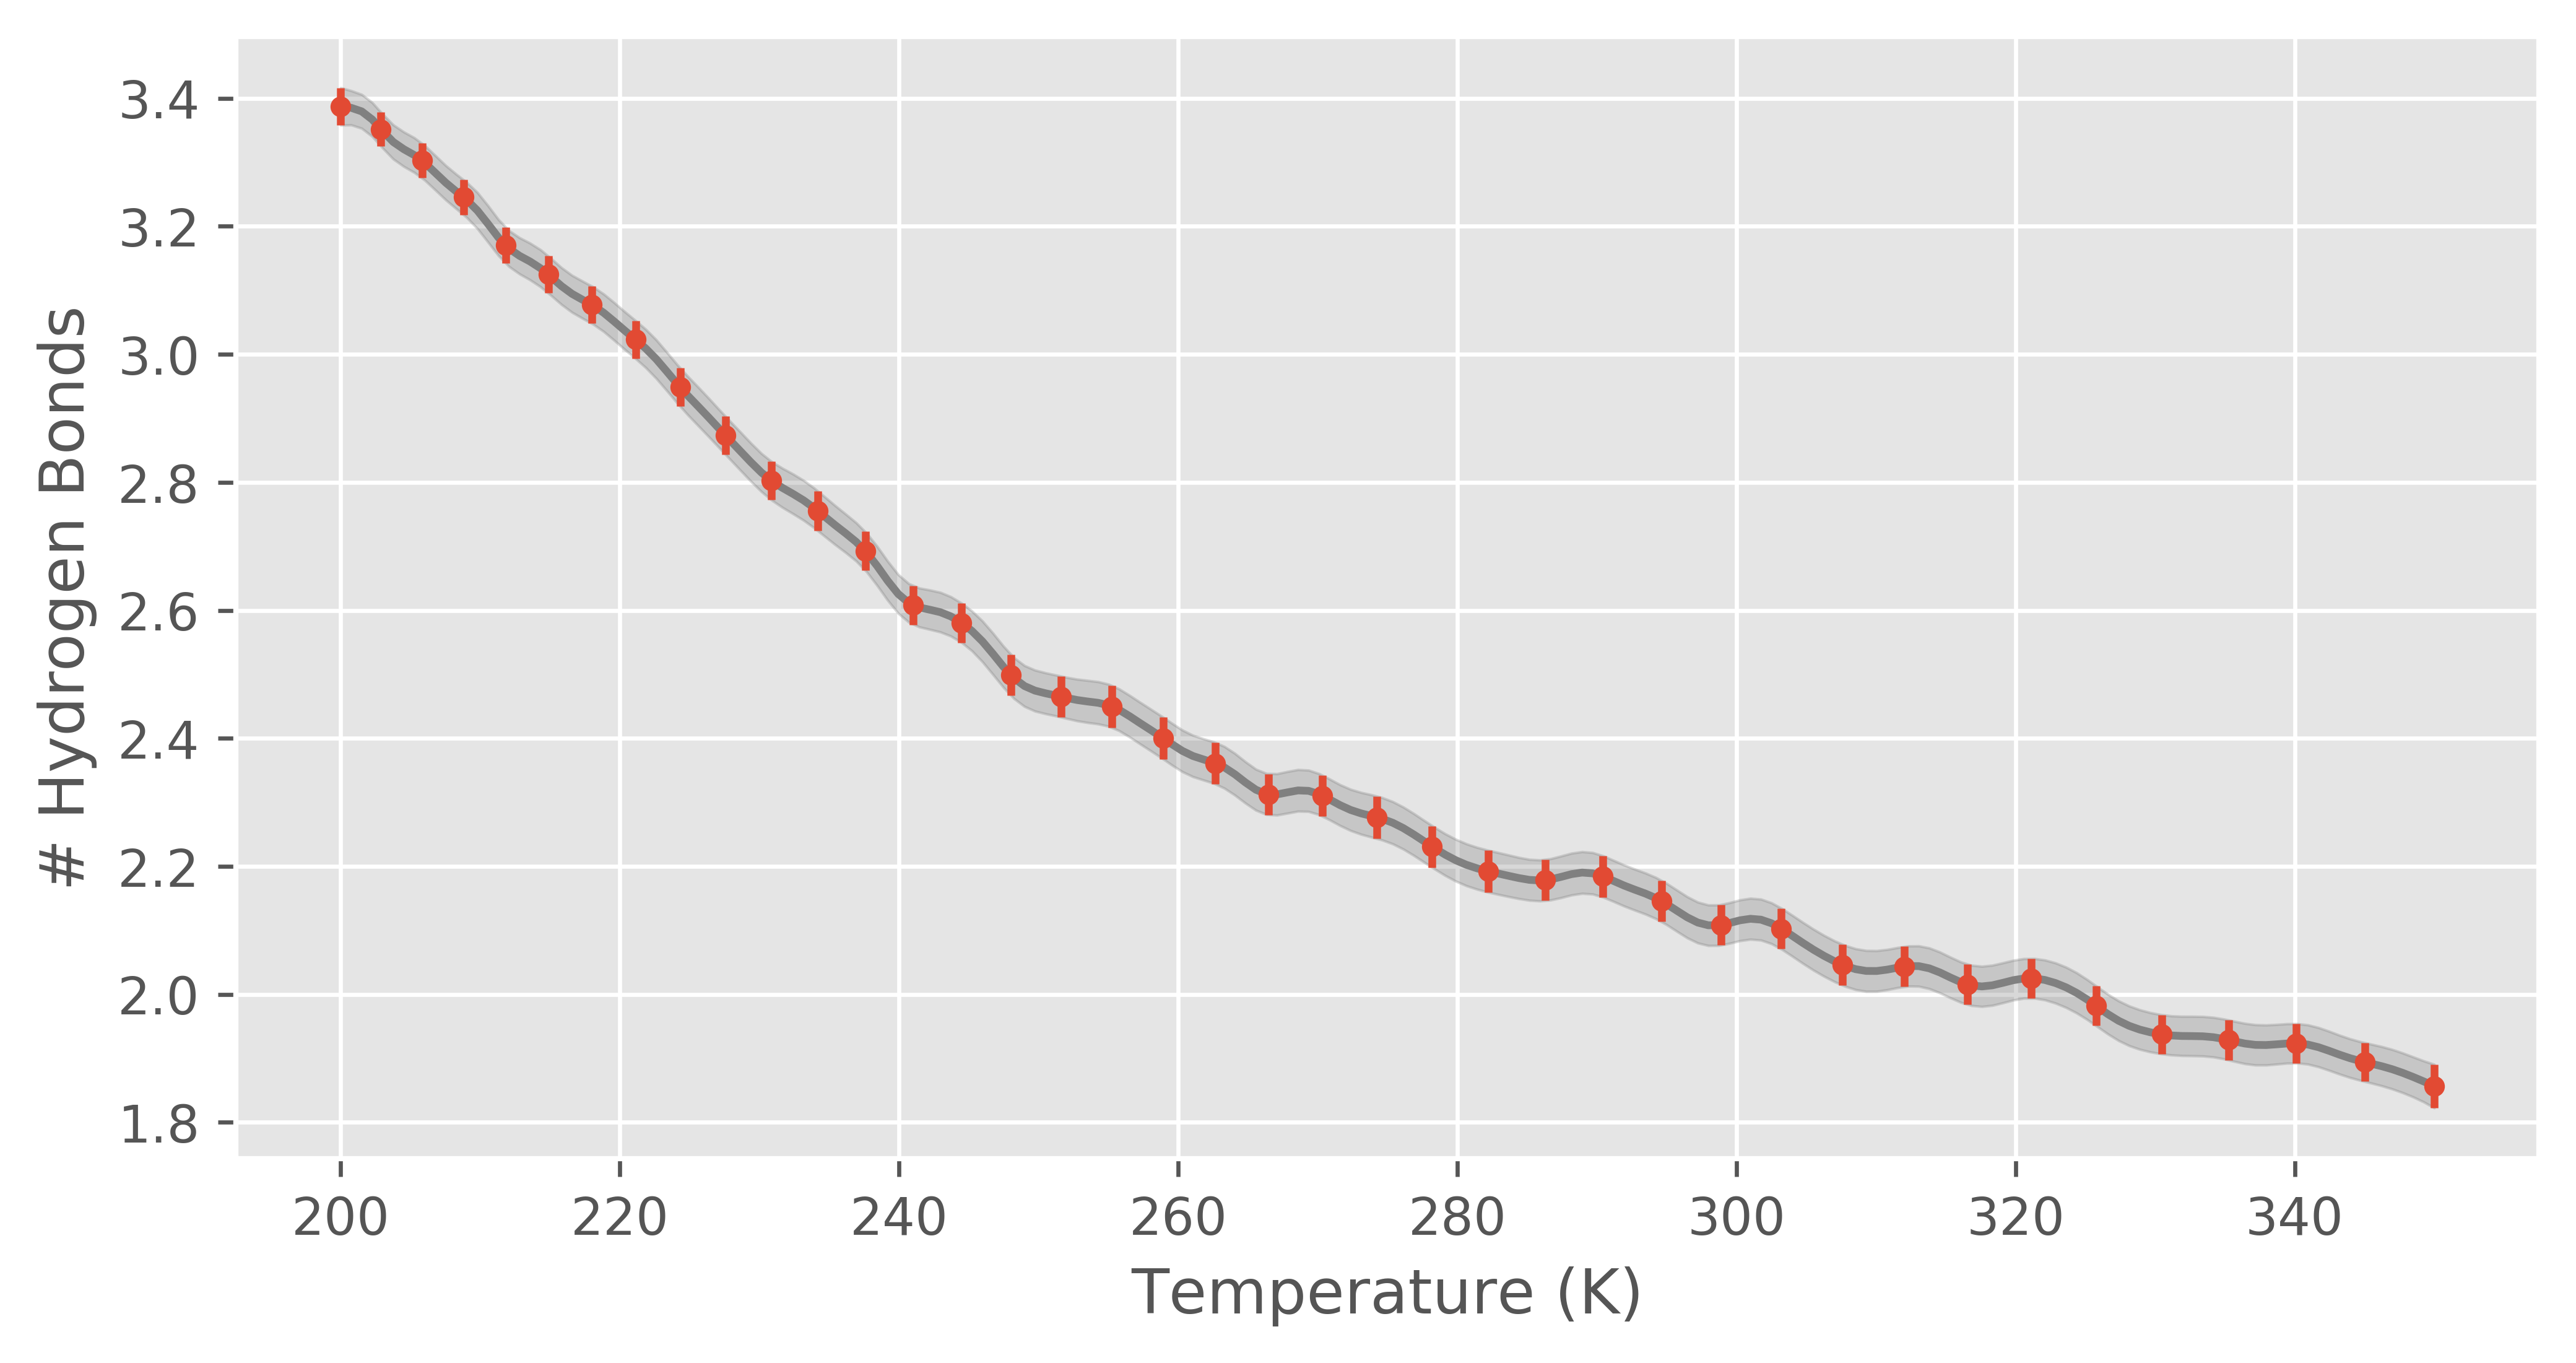

In [25]:
n_replicas = 40
plt.figure(figsize=[8,4], dpi=600)
# plt.scatter(t_list[:n_replicas], h_bonds_mu[:n_replicas])
plt.plot(t_list[n_replicas:], h_bonds_mu[n_replicas:], c="gray")
plt.errorbar(t_list[:n_replicas], h_bonds_mu[:n_replicas], yerr=2*h_bonds_sigma[:n_replicas], fmt=".")
plt.fill_between(t_list[n_replicas:], h_bonds_mu[n_replicas:]-2*h_bonds_sigma[n_replicas:],  h_bonds_mu[n_replicas:]+2*h_bonds_sigma[n_replicas:], color="gray", alpha = 0.3)


plt.ylabel("# Hydrogen Bonds")
plt.xlabel("Temperature (K)")

## Dihedral Analysis + Classification

We want to address what structural motifs are present in the terphenyl oligamer as it is subjected to the temperature changes of REMD. We will rerun the torsion analysis we ran on the vanilla MD simulations to confirm that the distributions are similar (meaning that we effectively sampled these distributions on our first pass) and to classify monomer structures to see what are typical conformations.

The goal of this analysis is to be able to extract specific frames coresponding to specific "classified" structures.

In [8]:
import utils

In [9]:
torsion_ids = ["A", "B", "CC", "D", "E", "F", "G"]

torsion_annotations = [[torsion_id + str(i) for i in range(1, 5)] for torsion_id in torsion_ids]

Here we output the atoms making up the torsion we want to look at. These torsions are extracted from an annotated .itp file which has speicifc atoms manually selected. There are torsions A-G (with C being represented as CC to not be confused with carbon naming). Here we show that can extract torsions at all temperatures.

In [10]:
itp_reader = utils.ReadItpFile("../OCT_dihes.itp")
selector = itp_reader.construct_dihe_selection(torsion_annotations[1])

In [11]:
dihes = utils.get_dihedrals(selector, remd_trajs.trajs[0])

In [12]:
torsions_temps = []
for i_rep in range(remd_trajs.n_replicas):
    dihes_t = utils.get_dihedrals(selector, remd_trajs.trajs[i_rep])
    torsions_temps.append(dihes_t)

Text(0, 0.5, 'Density')

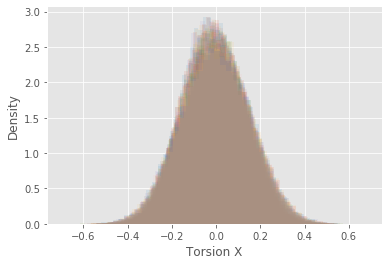

In [13]:
for torsions in torsions_temps:
    plt.hist(torsions, alpha = 0.1, bins=50, density=True)
plt.xlabel("Torsion X")
plt.ylabel("Density")

## All 1D Torsion Distributions

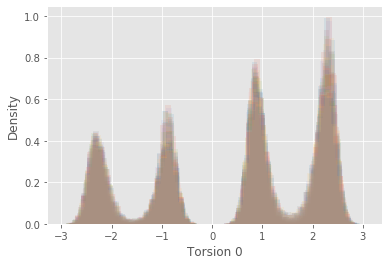

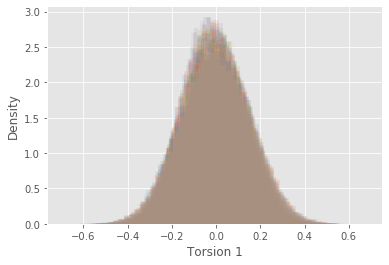

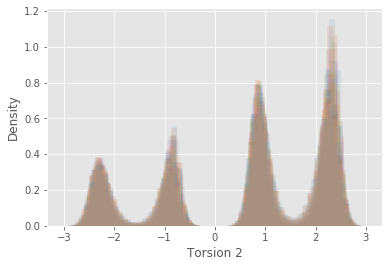

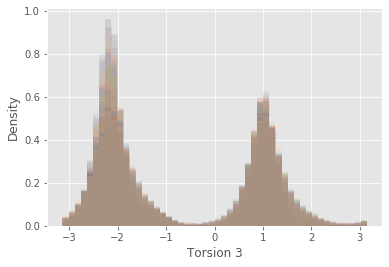

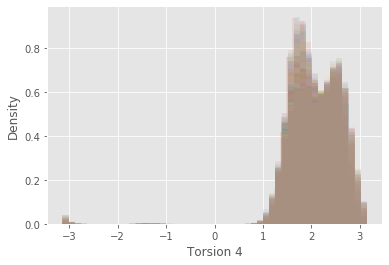

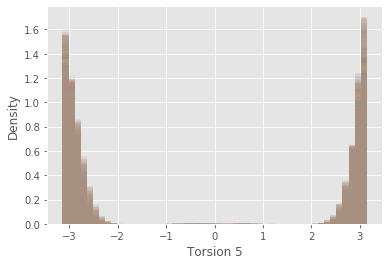

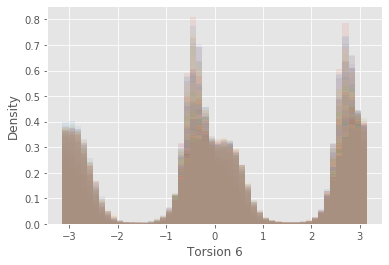

In [14]:
torsion_matrix = []
for i_torsions in range(len(torsion_annotations)):
    itp_reader = utils.ReadItpFile("../OCT_dihes.itp")
    selector = itp_reader.construct_dihe_selection(torsion_annotations[i_torsions])
    dihes = utils.get_dihedrals(selector, remd_trajs.trajs[0])
    torsions_temps = []
    for i_rep in range(remd_trajs.n_replicas):
        dihes_t = utils.get_dihedrals(selector, remd_trajs.trajs[i_rep])
        torsions_temps.append(dihes_t)
    plt.figure()
    for torsions in torsions_temps:
        hist = plt.hist(torsions, alpha = 0.1, bins=50, density=True)
    plt.xlabel("Torsion " + str(i_torsions))
    plt.ylabel("Density") 

## Monomer Classification

We can now extract the torsions for each temperature

In [15]:
classification_matrix = []
for i_torsions in range(len(torsion_annotations)):
    itp_reader = utils.ReadItpFile("../OCT_dihes.itp")
    selector = itp_reader.construct_dihe_selection(torsion_annotations[i_torsions])
    dihes = utils.get_dihedrals(selector, remd_trajs.trajs[0])
    torsions_temps = []
    for i_rep in range(remd_trajs.n_replicas):
        dihes_t = utils.get_dihedrals(selector, remd_trajs.trajs[i_rep])
        torsions_temps.append(dihes_t)
    all_torsions = np.array(torsions_temps)
    # print(all_torsions.shape)
    total_torsions = all_torsions.shape[1]
    all_torsions = all_torsions.reshape(6, all_torsions.shape[0], int(total_torsions/6))
    classification_matrix.append(all_torsions)
    
classification_matrix = np.array(classification_matrix)

In [16]:
# Indicies represent:
# 1. Torsions
# 2. Residues
# 3. Temperature
# 4. frames
print(classification_matrix.shape)

(7, 6, 40, 3608)


In [17]:
per_monomer_torsions = classification_matrix.reshape(classification_matrix.shape[0], -1)
print(per_monomer_torsions.shape)

# Convert to x and y components of torsions to remove periodic variables
per_monomer_torsions_comp = []
for i in range(per_monomer_torsions.shape[0]):
    per_monomer_torsions_comp.append(np.cos(per_monomer_torsions[i, :]))
    per_monomer_torsions_comp.append(np.sin(per_monomer_torsions[i, :]))
    print(np.sqrt(per_monomer_torsions[-1]**2 + per_monomer_torsions[-2]**2))
per_monomer_torsions_comp = np.array(per_monomer_torsions_comp)

(7, 865920)
[2.9195118 3.6242895 3.1988935 ... 3.0087106 4.350747  2.6160505]
[2.9195118 3.6242895 3.1988935 ... 3.0087106 4.350747  2.6160505]
[2.9195118 3.6242895 3.1988935 ... 3.0087106 4.350747  2.6160505]
[2.9195118 3.6242895 3.1988935 ... 3.0087106 4.350747  2.6160505]
[2.9195118 3.6242895 3.1988935 ... 3.0087106 4.350747  2.6160505]
[2.9195118 3.6242895 3.1988935 ... 3.0087106 4.350747  2.6160505]
[2.9195118 3.6242895 3.1988935 ... 3.0087106 4.350747  2.6160505]


In [18]:
per_monomer_torsions.shape

(7, 865920)

In [19]:
per_monomer_class = []
for i in range(per_monomer_torsions.shape[1]):
    id_str = ""
    torsions =  per_monomer_torsions[:, i]
    
    # Torsion 1
    if  torsions[0] >= -np.pi and torsions[0] <= -np.pi/2:
        id_str += "0"
    elif torsions[0] >= -np.pi/2 and torsions[0] <= 0:
        id_str += "1"
    elif torsions[0] >= 0 and torsions[0] <= np.pi/2:
        id_str += "2"
    elif torsions[0] >= np.pi/2 and torsions[0] <= np.pi:
        id_str += "3"
        
    # Torsion 2
    if  torsions[2] >= -np.pi and torsions[2] <= -np.pi/2:
        id_str += "0"
    elif torsions[2] >= -np.pi/2 and torsions[2] <= 0:
        id_str += "1"
    elif torsions[2] >= 0 and torsions[2] <= np.pi/2:
        id_str += "2"
    elif torsions[2] >= np.pi/2 and torsions[2] <= np.pi:
        id_str += "3"
    
    # Torsion 3
    if  torsions[3] >= - np.pi and torsions[3] <= 0:
        id_str += "0"
    elif  torsions[3] >= 0 and torsions[3] <= np.pi:
        id_str += "1"
        
    # Torsion 4
    if np.abs(torsions[6]) <= np.pi/2:
        id_str += "0"
    elif np.abs(torsions[6]) >= np.pi/2:
        id_str += "1"
        
    # Add to list
    per_monomer_class.append(id_str)
    
per_monomer_class = np.array(per_monomer_class)

In [20]:
unique, counts = np.unique(per_monomer_class, return_counts=True)
unique = [x for _,x in sorted(zip(counts, unique))][::-1]
counts = np.sort(counts)[::-1]
print("Total Populated Monomer Types:", len(unique))
for i in range(len(unique)):
    print(unique[i], ":", counts[i])

Total Populated Monomer Types: 64
3300 : 139592
1111 : 82998
3301 : 73997
2210 : 69210
2201 : 63700
2200 : 49860
2211 : 45023
0001 : 44325
3311 : 33675
0010 : 30678
3310 : 29845
0000 : 20029
1301 : 18130
0011 : 17893
1100 : 14416
1101 : 14349
0211 : 14014
1110 : 13678
0210 : 10205
2011 : 9567
1300 : 8346
0201 : 7665
3110 : 7373
0200 : 7088
2000 : 6145
1310 : 4425
3111 : 4334
2001 : 4164
1311 : 3990
3100 : 3951
2010 : 2964
3101 : 2780
3201 : 693
2301 : 648
2300 : 648
3200 : 641
2310 : 539
0111 : 497
2311 : 382
3210 : 373
3211 : 343
1011 : 323
0110 : 278
1010 : 247
1001 : 231
0311 : 219
0101 : 209
1000 : 128
0100 : 119
0301 : 113
3011 : 109
2111 : 93
0310 : 74
0300 : 72
1211 : 67
2110 : 66
1201 : 65
3010 : 63
3000 : 57
1200 : 57
2101 : 48
2100 : 47
1210 : 36
3001 : 26


In [21]:
import pandas
per_structure_temperature_class = per_monomer_class.reshape(6, 40, 3608)
pandas.DataFrame(per_structure_temperature_class[:, 0, 50:55])


0     1     2     3     4
0  2200  2200  0011  0011  2200
1  1101  1111  3300  3301  2201
2  2201  2200  3300  3300  1110
3  3300  3300  1301  1111  2200
4  3101  0011  2201  3301  3311
5  2211  3310  3300  2211  0011

In [22]:
for a, b in zip(*np.where(per_structure_temperature_class[:, 0, :] == "3300")):
    print("Frame:", b, "Residue", a)

Frame: 114 Residue 0
Frame: 128 Residue 0
Frame: 129 Residue 0
Frame: 132 Residue 0
Frame: 140 Residue 0
Frame: 141 Residue 0
Frame: 146 Residue 0
Frame: 147 Residue 0
Frame: 152 Residue 0
Frame: 153 Residue 0
Frame: 164 Residue 0
Frame: 165 Residue 0
Frame: 168 Residue 0
Frame: 170 Residue 0
Frame: 174 Residue 0
Frame: 176 Residue 0
Frame: 182 Residue 0
Frame: 183 Residue 0
Frame: 188 Residue 0
Frame: 189 Residue 0
Frame: 194 Residue 0
Frame: 195 Residue 0
Frame: 200 Residue 0
Frame: 201 Residue 0
Frame: 204 Residue 0
Frame: 206 Residue 0
Frame: 210 Residue 0
Frame: 212 Residue 0
Frame: 213 Residue 0
Frame: 216 Residue 0
Frame: 218 Residue 0
Frame: 219 Residue 0
Frame: 222 Residue 0
Frame: 224 Residue 0
Frame: 228 Residue 0
Frame: 230 Residue 0
Frame: 231 Residue 0
Frame: 234 Residue 0
Frame: 236 Residue 0
Frame: 237 Residue 0
Frame: 240 Residue 0
Frame: 242 Residue 0
Frame: 243 Residue 0
Frame: 246 Residue 0
Frame: 249 Residue 0
Frame: 252 Residue 0
Frame: 255 Residue 0
Frame: 258 Re

Frame: 3440 Residue 0
Frame: 3441 Residue 0
Frame: 3446 Residue 0
Frame: 3447 Residue 0
Frame: 3451 Residue 0
Frame: 3458 Residue 0
Frame: 3463 Residue 0
Frame: 3470 Residue 0
Frame: 3471 Residue 0
Frame: 3475 Residue 0
Frame: 3481 Residue 0
Frame: 3488 Residue 0
Frame: 3489 Residue 0
Frame: 3494 Residue 0
Frame: 3495 Residue 0
Frame: 3500 Residue 0
Frame: 3501 Residue 0
Frame: 3506 Residue 0
Frame: 3507 Residue 0
Frame: 3512 Residue 0
Frame: 3513 Residue 0
Frame: 3518 Residue 0
Frame: 3519 Residue 0
Frame: 3524 Residue 0
Frame: 3525 Residue 0
Frame: 3530 Residue 0
Frame: 3531 Residue 0
Frame: 3535 Residue 0
Frame: 3542 Residue 0
Frame: 3543 Residue 0
Frame: 3546 Residue 0
Frame: 3548 Residue 0
Frame: 3549 Residue 0
Frame: 3554 Residue 0
Frame: 3555 Residue 0
Frame: 3558 Residue 0
Frame: 3560 Residue 0
Frame: 3561 Residue 0
Frame: 3564 Residue 0
Frame: 3566 Residue 0
Frame: 3567 Residue 0
Frame: 3570 Residue 0
Frame: 3572 Residue 0
Frame: 3573 Residue 0
Frame: 3578 Residue 0
Frame: 357

Frame: 2493 Residue 2
Frame: 2498 Residue 2
Frame: 2506 Residue 2
Frame: 2511 Residue 2
Frame: 2513 Residue 2
Frame: 2516 Residue 2
Frame: 2524 Residue 2
Frame: 2525 Residue 2
Frame: 2530 Residue 2
Frame: 2531 Residue 2
Frame: 2534 Residue 2
Frame: 2542 Residue 2
Frame: 2543 Residue 2
Frame: 2554 Residue 2
Frame: 2555 Residue 2
Frame: 2559 Residue 2
Frame: 2561 Residue 2
Frame: 2566 Residue 2
Frame: 2567 Residue 2
Frame: 2572 Residue 2
Frame: 2573 Residue 2
Frame: 2578 Residue 2
Frame: 2579 Residue 2
Frame: 2584 Residue 2
Frame: 2585 Residue 2
Frame: 2594 Residue 2
Frame: 2596 Residue 2
Frame: 2602 Residue 2
Frame: 2603 Residue 2
Frame: 2609 Residue 2
Frame: 2614 Residue 2
Frame: 2620 Residue 2
Frame: 2626 Residue 2
Frame: 2632 Residue 2
Frame: 2637 Residue 2
Frame: 2643 Residue 2
Frame: 2650 Residue 2
Frame: 2657 Residue 2
Frame: 2663 Residue 2
Frame: 2668 Residue 2
Frame: 2674 Residue 2
Frame: 2681 Residue 2
Frame: 2686 Residue 2
Frame: 2687 Residue 2
Frame: 2690 Residue 2
Frame: 269

Frame: 2479 Residue 4
Frame: 2482 Residue 4
Frame: 2485 Residue 4
Frame: 2536 Residue 4
Frame: 2537 Residue 4
Frame: 2543 Residue 4
Frame: 2549 Residue 4
Frame: 2555 Residue 4
Frame: 2561 Residue 4
Frame: 2573 Residue 4
Frame: 2591 Residue 4
Frame: 2596 Residue 4
Frame: 2603 Residue 4
Frame: 2609 Residue 4
Frame: 2638 Residue 4
Frame: 2656 Residue 4
Frame: 2677 Residue 4
Frame: 2683 Residue 4
Frame: 2701 Residue 4
Frame: 2707 Residue 4
Frame: 2713 Residue 4
Frame: 2731 Residue 4
Frame: 2737 Residue 4
Frame: 2743 Residue 4
Frame: 2767 Residue 4
Frame: 2773 Residue 4
Frame: 2797 Residue 4
Frame: 2832 Residue 4
Frame: 2838 Residue 4
Frame: 2845 Residue 4
Frame: 2863 Residue 4
Frame: 2868 Residue 4
Frame: 2880 Residue 4
Frame: 2886 Residue 4
Frame: 2891 Residue 4
Frame: 2893 Residue 4
Frame: 2903 Residue 4
Frame: 2905 Residue 4
Frame: 2927 Residue 4
Frame: 2932 Residue 4
Frame: 2938 Residue 4
Frame: 2945 Residue 4
Frame: 2947 Residue 4
Frame: 2951 Residue 4
Frame: 2953 Residue 4
Frame: 295

In [23]:
per_structure_temperature_class.shape

(6, 40, 3608)

In [48]:
configurations_temp_traj = np.array([["".join(per_structure_temperature_class[:,i,j]) for j in range(per_structure_temperature_class.shape[2])] for i in range(per_structure_temperature_class.shape[1])])
test = configurations_temp_traj[0]
test

array(['220033101111330022100011', '220133000000220122010001',
       '220011003300220000113311', ..., '001022003300000122113300',
       '330033001111330022010011', '330133001111221133001110'],
      dtype='<U24')

In [51]:
# Go from 3608 vector of configrations to a 3608x3608 matrix of distances
dist_matrix = np.zeros([test.shape[0],test.shape[0]])
for i in range(test.shape[0]):
    for j in range(test.shape[0]):
        dist_matrix[i, j] = sum([int(test[i][k] != test[j][k]) for k in range(len(test[0]))])
print(dist_matrix)

[[ 0. 12. 14. ... 18.  5. 14.]
 [12.  0. 12. ... 14. 11. 14.]
 [14. 12.  0. ... 12. 15. 18.]
 ...
 [18. 14. 12. ...  0. 17. 20.]
 [ 5. 11. 15. ... 17.  0. 11.]
 [14. 14. 18. ... 20. 11.  0.]]


In [52]:
np.average(dist_matrix)

14.539570694096883

## K-Means Clustering

In [26]:
from sklearn.cluster import KMeans

k_means = KMeans(n_clusters=10)
k_means.fit(dist_matrix)

KMeans(n_clusters=10)

In [27]:
k_means.labels_

array([3, 9, 2, ..., 0, 3, 9], dtype=int32)

For n_clusters = 5 The average silhouette_score is : 0.15623783088646948
For n_clusters = 6 The average silhouette_score is : 0.1233969657758601
For n_clusters = 7 The average silhouette_score is : 0.11535285133510084
For n_clusters = 8 The average silhouette_score is : 0.11277892803612562
For n_clusters = 9 The average silhouette_score is : 0.1054365311307095
For n_clusters = 10 The average silhouette_score is : 0.10751207061899298
For n_clusters = 11 The average silhouette_score is : 0.09949050528573426
For n_clusters = 12 The average silhouette_score is : 0.09822652538010644
For n_clusters = 13 The average silhouette_score is : 0.09691204055909863
For n_clusters = 14 The average silhouette_score is : 0.09435761053778353


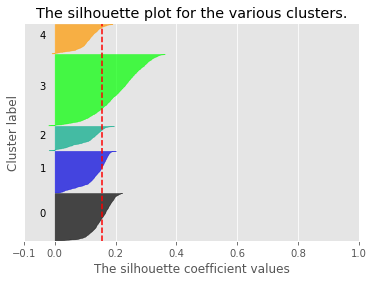

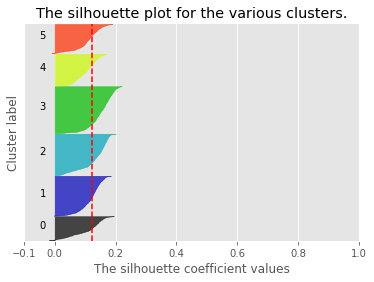

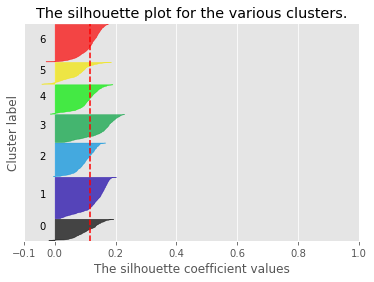

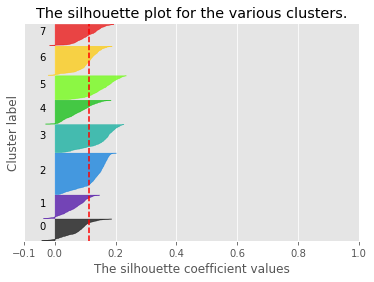

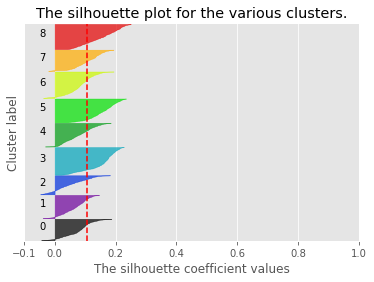

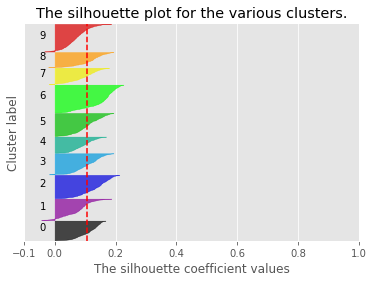

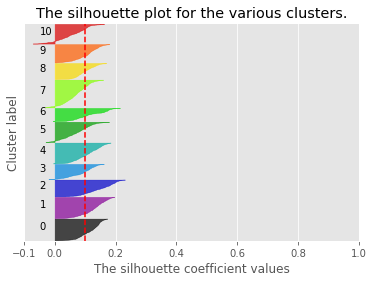

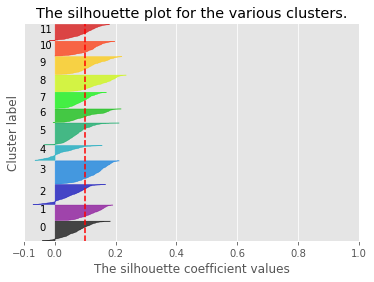

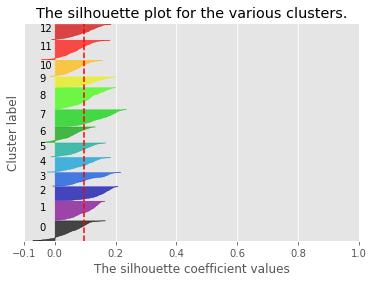

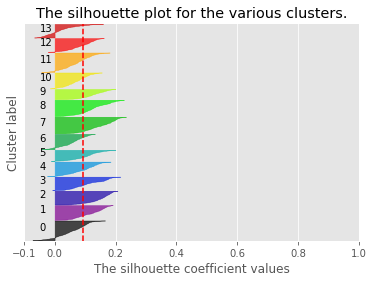

In [28]:
from sklearn.datasets import make_blobs
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_samples, silhouette_score

import matplotlib.pyplot as plt
import matplotlib.cm as cm
import numpy as np

range_n_clusters = np.arange(5, 15, 1)

for n_clusters in range_n_clusters:
    # Create a subplot with 1 row and 2 columns
    fig, ax1= plt.subplots(1, 1)

    # The 1st subplot is the silhouette plot
    # The silhouette coefficient can range from -1, 1 but in this example all
    # lie within [-0.1, 1]
    ax1.set_xlim([-0.1, 1])
    # The (n_clusters+1)*10 is for inserting blank space between silhouette
    # plots of individual clusters, to demarcate them clearly.
    ax1.set_ylim([0, len(dist_matrix) + (n_clusters + 1) * 10])

    # Initialize the clusterer with n_clusters value and a random generator
    # seed of 10 for reproducibility.
    clusterer = KMeans(n_clusters=n_clusters, random_state=10)
    cluster_labels = clusterer.fit_predict(dist_matrix)

    # The silhouette_score gives the average value for all the samples.
    # This gives a perspective into the density and separation of the formed
    # clusters
    silhouette_avg = silhouette_score(dist_matrix, cluster_labels)
    print("For n_clusters =", n_clusters,
          "The average silhouette_score is :", silhouette_avg)

    # Compute the silhouette scores for each sample
    sample_silhouette_values = silhouette_samples(dist_matrix, cluster_labels)

    y_lower = 10
    for i in range(n_clusters):
        # Aggregate the silhouette scores for samples belonging to
        # cluster i, and sort them
        ith_cluster_silhouette_values = \
            sample_silhouette_values[cluster_labels == i]

        ith_cluster_silhouette_values.sort()

        size_cluster_i = ith_cluster_silhouette_values.shape[0]
        y_upper = y_lower + size_cluster_i

        color = cm.nipy_spectral(float(i) / n_clusters)
        ax1.fill_betweenx(np.arange(y_lower, y_upper),
                          0, ith_cluster_silhouette_values,
                          facecolor=color, edgecolor=color, alpha=0.7)

        # Label the silhouette plots with their cluster numbers at the middle
        ax1.text(-0.05, y_lower + 0.5 * size_cluster_i, str(i))

        # Compute the new y_lower for next plot
        y_lower = y_upper + 10  # 10 for the 0 samples

    ax1.set_title("The silhouette plot for the various clusters.")
    ax1.set_xlabel("The silhouette coefficient values")
    ax1.set_ylabel("Cluster label")

    # The vertical line for average silhouette score of all the values
    ax1.axvline(x=silhouette_avg, color="red", linestyle="--")

    ax1.set_yticks([])  # Clear the yaxis labels / ticks
    ax1.set_xticks([-0.1, 0, 0.2, 0.4, 0.6, 0.8, 1])

    # Labeling the clusters
    centers = clusterer.cluster_centers_

plt.show()

In [29]:
np.unique(k_means.labels_, return_counts=True)

(array([0, 1, 2, 3, 4, 5, 6, 7, 8, 9], dtype=int32),
 array([348, 362, 364, 384, 444, 241, 412, 471, 272, 310]))

In [ ]:
k_means.labels_

In [50]:
for i_cluster in np.unique(k_means.labels_):
    print("Cluster index", i_cluster)
    cluster_index = np.where(k_means.labels_ == i_cluster)
    print(test[cluster_index])
    cluster = remd_trajs.trajs[0][cluster_index]
    cluster.save("test_" + str(i_cluster) + ".pdb")

Cluster index 0
['001133113311111113103311' '001133003300130122013300'
 '001133013300130122013301' '001122103311111113013311'
 '001122103311001131113300' '001133003311001122013301'
 '130033013300111022103300' '000033012201000113013300'
 '130033003301111033002201' '000033012211000102112210'
 '130022113300001113003311' '000033012201111122102201'
 '130033013301111033103300' '000033012211000133113300'
 '001122111310001102003300' '130022103300111033003300'
 '000022002201000102012201' '130022011310001122103300'
 '000022112210111120113300' '130022013311111122113300'
 '000022112201111131102201' '130022013300001122103300'
 '000022113300001120112201' '130022013110111133003300'
 '000022112211001133013300' '000033013311001122012200'
 '000022113301111131103310' '130033012201111002003311'
 '000022003300000122102210' '130033013300001133001300'
 '000033012201001133012200' '000033003311000120113301'
 '130033003300111133103311' '000002013300111113013301'
 '130022103300111122012201' '00002200330011113301

Cluster index 1
['330000103301220100013311' '330011113301220100113300'
 '330000103301220013113110' '330011113301220100113311'
 '330011113301220000111300' '330000002201220011112311'
 '330011112201220011112211' '330011111310220000103311'
 '330000102200220002112210' '330000012011220011111300'
 '330000102201220011103310' '330000013301220011001300'
 '330011003310220002112210' '330011113301220011113311'
 '330011003300220100013311' '330000013301220011113301'
 '330011113300220013003310' '330011113301220000001300'
 '330000102201220011113300' '330000013301220000103300'
 '330000103300220011112210' '330000013310220000102200'
 '330000102211220011102210' '330000102200220011012211'
 '330011112201220011012000' '330000103301220000113300'
 '330011112211220000002200' '330000103301220100012201'
 '330011113301220011113311' '330000003301220100003311'
 '330011102210220100112211' '330000103301220000113301'
 '330011013301220000002210' '330000103110220000111300'
 '330000013300220000013310' '33001111331022000201

Cluster index 2
['220011003300220000113311' '220000012211220031012210'
 '220000002210330011112200' '220013113301330020013110'
 '220011112210220100112200' '220000103300220000113110'
 '220020113301330000112200' '220011113311220000113110'
 '220000003301220000112210' '220013113311220000112210'
 '220011002211330002110201' '220000012211330011013301'
 '220013013301330011013301' '220000102200330011003310'
 '220000002211330000010201' '220000102211330011013301'
 '220011012201330031012211' '220011112200330000113310'
 '220013012200220000012200' '220000102011220002012211'
 '220000003300220000012200' '220000102211220000002211'
 '220011012210330011003301' '220011113301330011003310'
 '220002113300220031012200' '220011012211330000112211'
 '220011003301330011103311' '220011112200330000012210'
 '220002112200330000013311' '220011012011330002012210'
 '220013012200220011102200' '220000102011220000013310'
 '220000002210220031012201' '220000013301330013110211'
 '220000002200220000003311' '22000001201122001100

Cluster index 3
['220033101111330022100011' '220033001111330022100011'
 '220020001111330033011101' '220033000211330033111101'
 '220033101100330022100011' '220033001101330033010001'
 '220013001111330002110001' '220033011111330013011101'
 '220013001101330033111111' '220033001111330033011100'
 '220113010001330133110011' '220033001111330022011100'
 '220133001111330122110010' '330013001111330022101111'
 '330133101110331033011101' '330133001111331033010001'
 '220013000211330033111111' '330133000010331033011111'
 '330033000010330022010211' '330033011111331022111111'
 '220133000011330133010000' '330033000200331022010001'
 '330133001111330133111310' '330133001100330022010211'
 '220033000001330122010010' '330033002011331033111111'
 '330133001111330033111111' '330133001301330033010011'
 '220033000010330122100001' '330133001301330033010010'
 '330033010001330022010011' '330033001101330033110001'
 '330033001101330033010001' '330133000211330033010001'
 '220031101101330133010001' '33013300001033013311

Cluster index 4
['111133013300111122102201' '001133003300111102003311'
 '001103013300111133103300' '001122003300111133103300'
 '111122113310111133103300' '111122113310001133002210'
 '111133003300001122102200' '111133013300111123002201'
 '111133013300130133003311' '111133003300111133012200'
 '111122113300111113102201' '001133013300111133012211'
 '001133003300001122112211' '111122113300001131103301'
 '001133013300111133013311' '001133013300111113102201'
 '001122013300111122102211' '001122113300111133013301'
 '001133003311111122103301' '001122103300111120113301'
 '001133003300001122013300' '111133013300111133112200'
 '111133011310111113003310' '111122111310001102001301'
 '111122113300111133003300' '111122113300111033013301'
 '111133013300111133002210' '111122113300001122002201'
 '111122013110001033003300' '001122011301001133002210'
 '111122113300001102012210' '001122013311001122113300'
 '111122113301001131102211' '001122013300111122103300'
 '111133013300001133012210' '11112201330000102201

Cluster index 5
['220131101111220102100001' '220022012011330000010001'
 '220022102011330002111101' '220122101111330133000000'
 '220022011110220033110011' '220022101111330022111101'
 '220122100010220122010210' '220122000000330133000011'
 '220122100010330122110310' '220122001110220133011101'
 '220022011111220013011111' '220131101110220133010000'
 '220122001111330102100000' '220022100001220122101111'
 '220022011111220122101111' '220122001101220122000000'
 '220022010001220122100000' '220122010001330122100010'
 '220022011111220133000000' '220022100000220113011301'
 '220122101111221013000000' '220122010010220133100010'
 '220022101111330133111101' '220022101111330033010001'
 '220022001111220133000010' '220022101111221133001101'
 '220022101111220133011301' '220122100011220033001101'
 '220022101111220133010001' '220022010001220122011310'
 '220022101101330122001110' '220022100011330033010000'
 '220022101111220122011100' '220022010001330133000210'
 '220022010001330113001310' '22002210111133002210

Cluster index 7
['330013012210330100002211' '330013012211330111012211'
 '330013012210330002112200' '330011112211230111012211'
 '330011112210330111013310' '330011112210330011012211'
 '220011113301330000113311' '220011113301330000003300'
 '330000103300330011112210' '330000103310330013002210'
 '330000012211330000003301' '330000103301331000012200'
 '330011003301320011102211' '330011113311330000013301'
 '330011112200330000013300' '330000103110330011013300'
 '330000013300330111103310' '330011112201330000002210'
 '330011102200330000113310' '330011113301330000013311'
 '330000013301330002111300' '330000003301330011112201'
 '330011102211330000012200' '330013113311330000012211'
 '330011113301330000013301' '330011113301330011003300'
 '220011113300330000012211' '330013013311330011102000'
 '330000102211330000013300' '330011113301330100012200'
 '330011113311330000013300' '330000103301330100013311'
 '330011112211330102013301' '330000102211330000012211'
 '330000012211330002012210' '33000001331133000201

Cluster index 8
['330022011111330033011100' '330122011111331033010010'
 '330122010211330022011111' '330122010010220022101111'
 '330122011111220022100211' '330022011301330033000001'
 '330022011301330022100211' '330022011111330020001100'
 '330022010010220020001111' '330022010001220122100011'
 '330122101111220133011111' '330122101100220133000210'
 '330100010010331022101111' '330122011111221022011110'
 '330122101101220033010011' '330000011101220133100011'
 '330122100010330102000001' '330131100010220133010210'
 '330122010010330133010000' '330022011301220133110211'
 '330122102011331033010010' '330022100001330033010001'
 '330122100001220033011111' '330120002011330033010001'
 '330122010001220033010001' '330120000211330033110010'
 '330033100211220012110011' '330122100001330033110011'
 '330122012011330033110211' '330122102011220033111100'
 '330022101110330022110001' '330022102011330033010011'
 '330122100211330033000011' '330122010211221122100000'
 '330122011101220122100001' '33012201111022103311

## Clustering based on angle components

In [31]:
from sklearn.cluster import MeanShift, estimate_bandwidth

In [32]:
bandwidth = estimate_bandwidth(per_monomer_torsions_comp.T, quantile=0.4, n_jobs=-1, n_samples = 1000)

In [33]:
bandwidth = 1.53

In [34]:
ms = MeanShift(bandwidth=bandwidth, bin_seeding=True, n_jobs=-1)

In [35]:
ms.fit(per_monomer_torsions_comp.T)

MeanShift(bandwidth=1.53, bin_seeding=True, n_jobs=-1)

In [36]:
labels = ms.labels_
np.unique(labels)

array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16])

In [37]:
label_per_residue_temp_frame = labels.reshape(*classification_matrix.shape[1:])
label_per_residue_temp_frame.shape

(6, 40, 3608)

In [38]:
loc = np.where(label_per_residue_temp_frame == 0)
np.array(loc).T.shape

(163089, 3)

In [39]:
unique, counts = np.unique(labels,return_counts=True)

In [40]:
unique

array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16])

In [41]:
counts

array([163089, 145127,  95834,  81483,  98632,  58838,  50028,  28531,
        22895,  18373,  42454,  16908,  13637,  10178,  11004,   7253,
         1656])

In [42]:
ms.cluster_centers_.shape

(17, 14)

In [43]:
cluster_torsions = [np.arctan2(ms.cluster_centers_[:, 2*i + 1], ms.cluster_centers_[:, 2*i]) for i in range(7)]
cluster_torsions = np.array(cluster_torsions)
cluster_torsions.shape

(7, 17)

In [44]:
np.arctan(1) * 180 / np.pi

45.0

In [45]:
per_monomer_torsions_comp

array([[ 0.54421806,  0.5034123 ,  0.47756532, ...,  0.7033245 ,
         0.56088763,  0.5264379 ],
       [ 0.8389438 ,  0.86404634,  0.87859625, ...,  0.71086895,
        -0.82789195, -0.85021365],
       [ 0.9985589 ,  0.9994662 ,  0.9991333 , ...,  0.9842105 ,
         0.9994744 ,  0.9966647 ],
       ...,
       [ 0.2731803 ,  0.19684869,  0.02096967, ...,  0.16551052,
         0.07691923,  0.53002876],
       [ 0.8461528 , -0.51740366,  0.7627074 , ...,  0.9017385 ,
        -0.99857724,  0.91520286],
       [ 0.5329404 , -0.85574144,  0.6467437 , ..., -0.4322819 ,
         0.05332482,  0.40299344]], dtype=float32)

In [46]:
cluster_torsions[:,0].shape

(7,)

[0.89411765 0.10196078 0.10980392 1.        ]
[0.89411765 0.10196078 0.10980392 1.        ]
[0.21568627 0.49411765 0.72156863 1.        ]
[0.21568627 0.49411765 0.72156863 1.        ]
[0.30196078 0.68627451 0.29019608 1.        ]
[0.30196078 0.68627451 0.29019608 1.        ]
[0.59607843 0.30588235 0.63921569 1.        ]


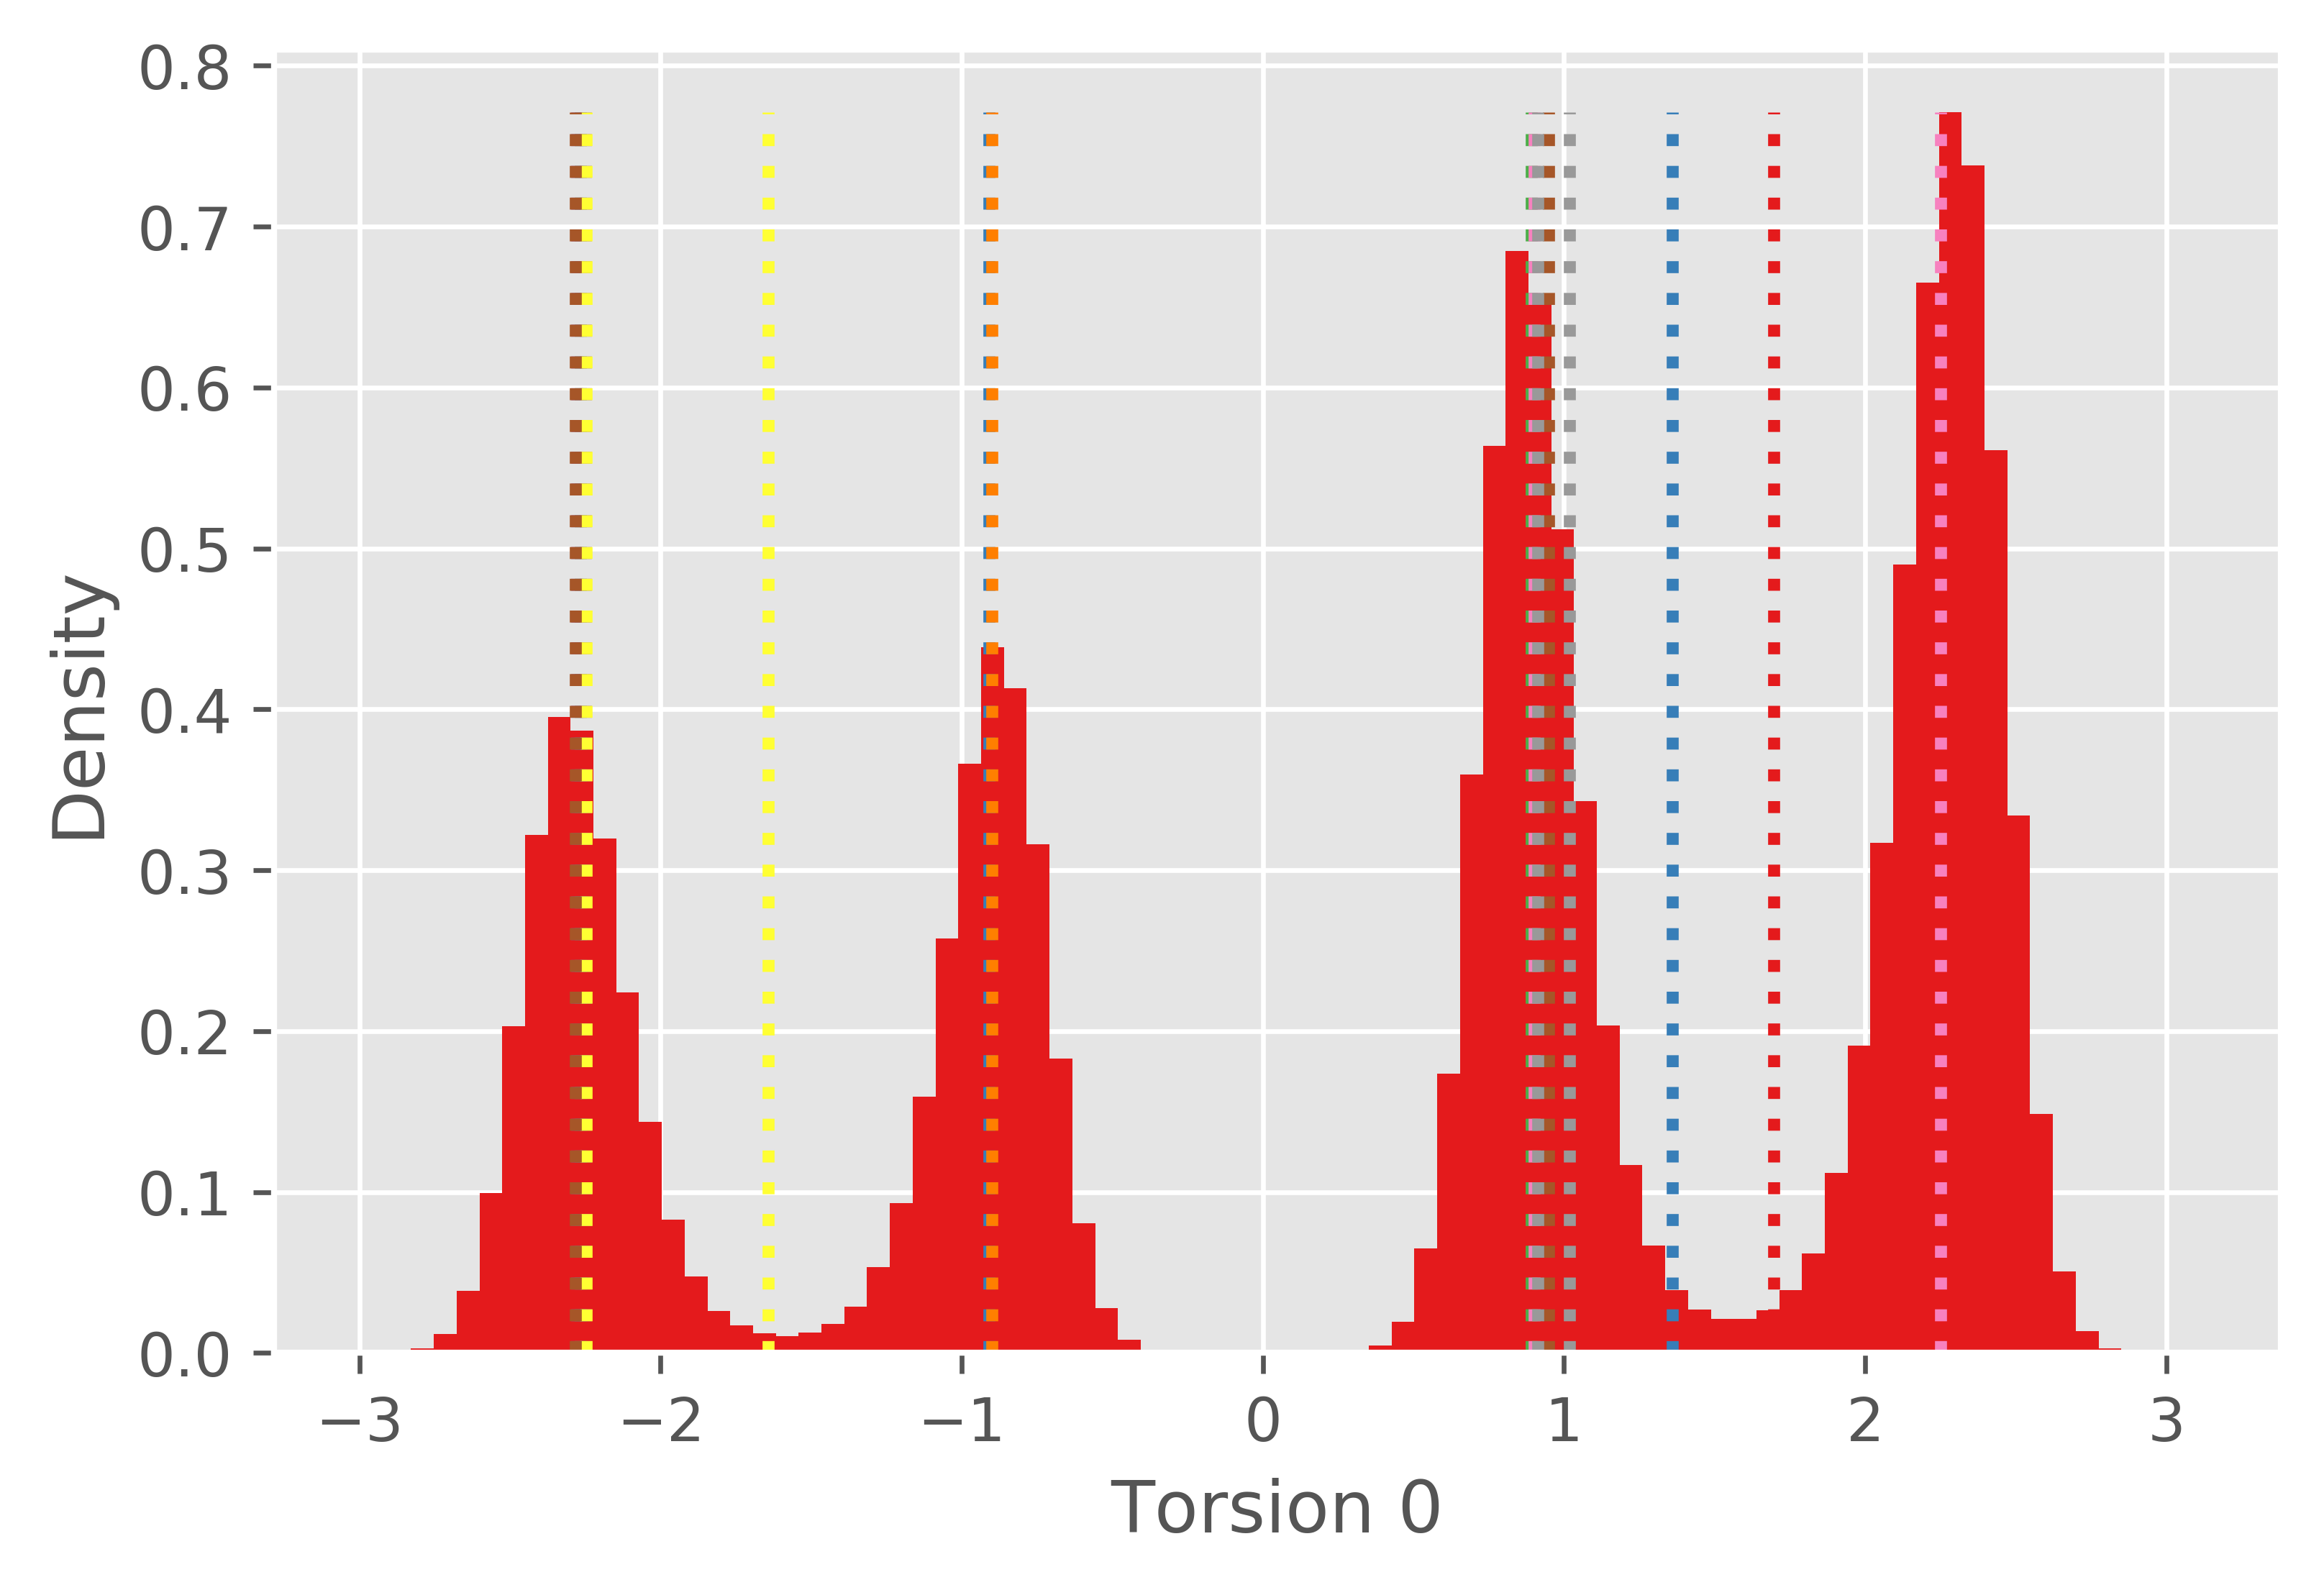

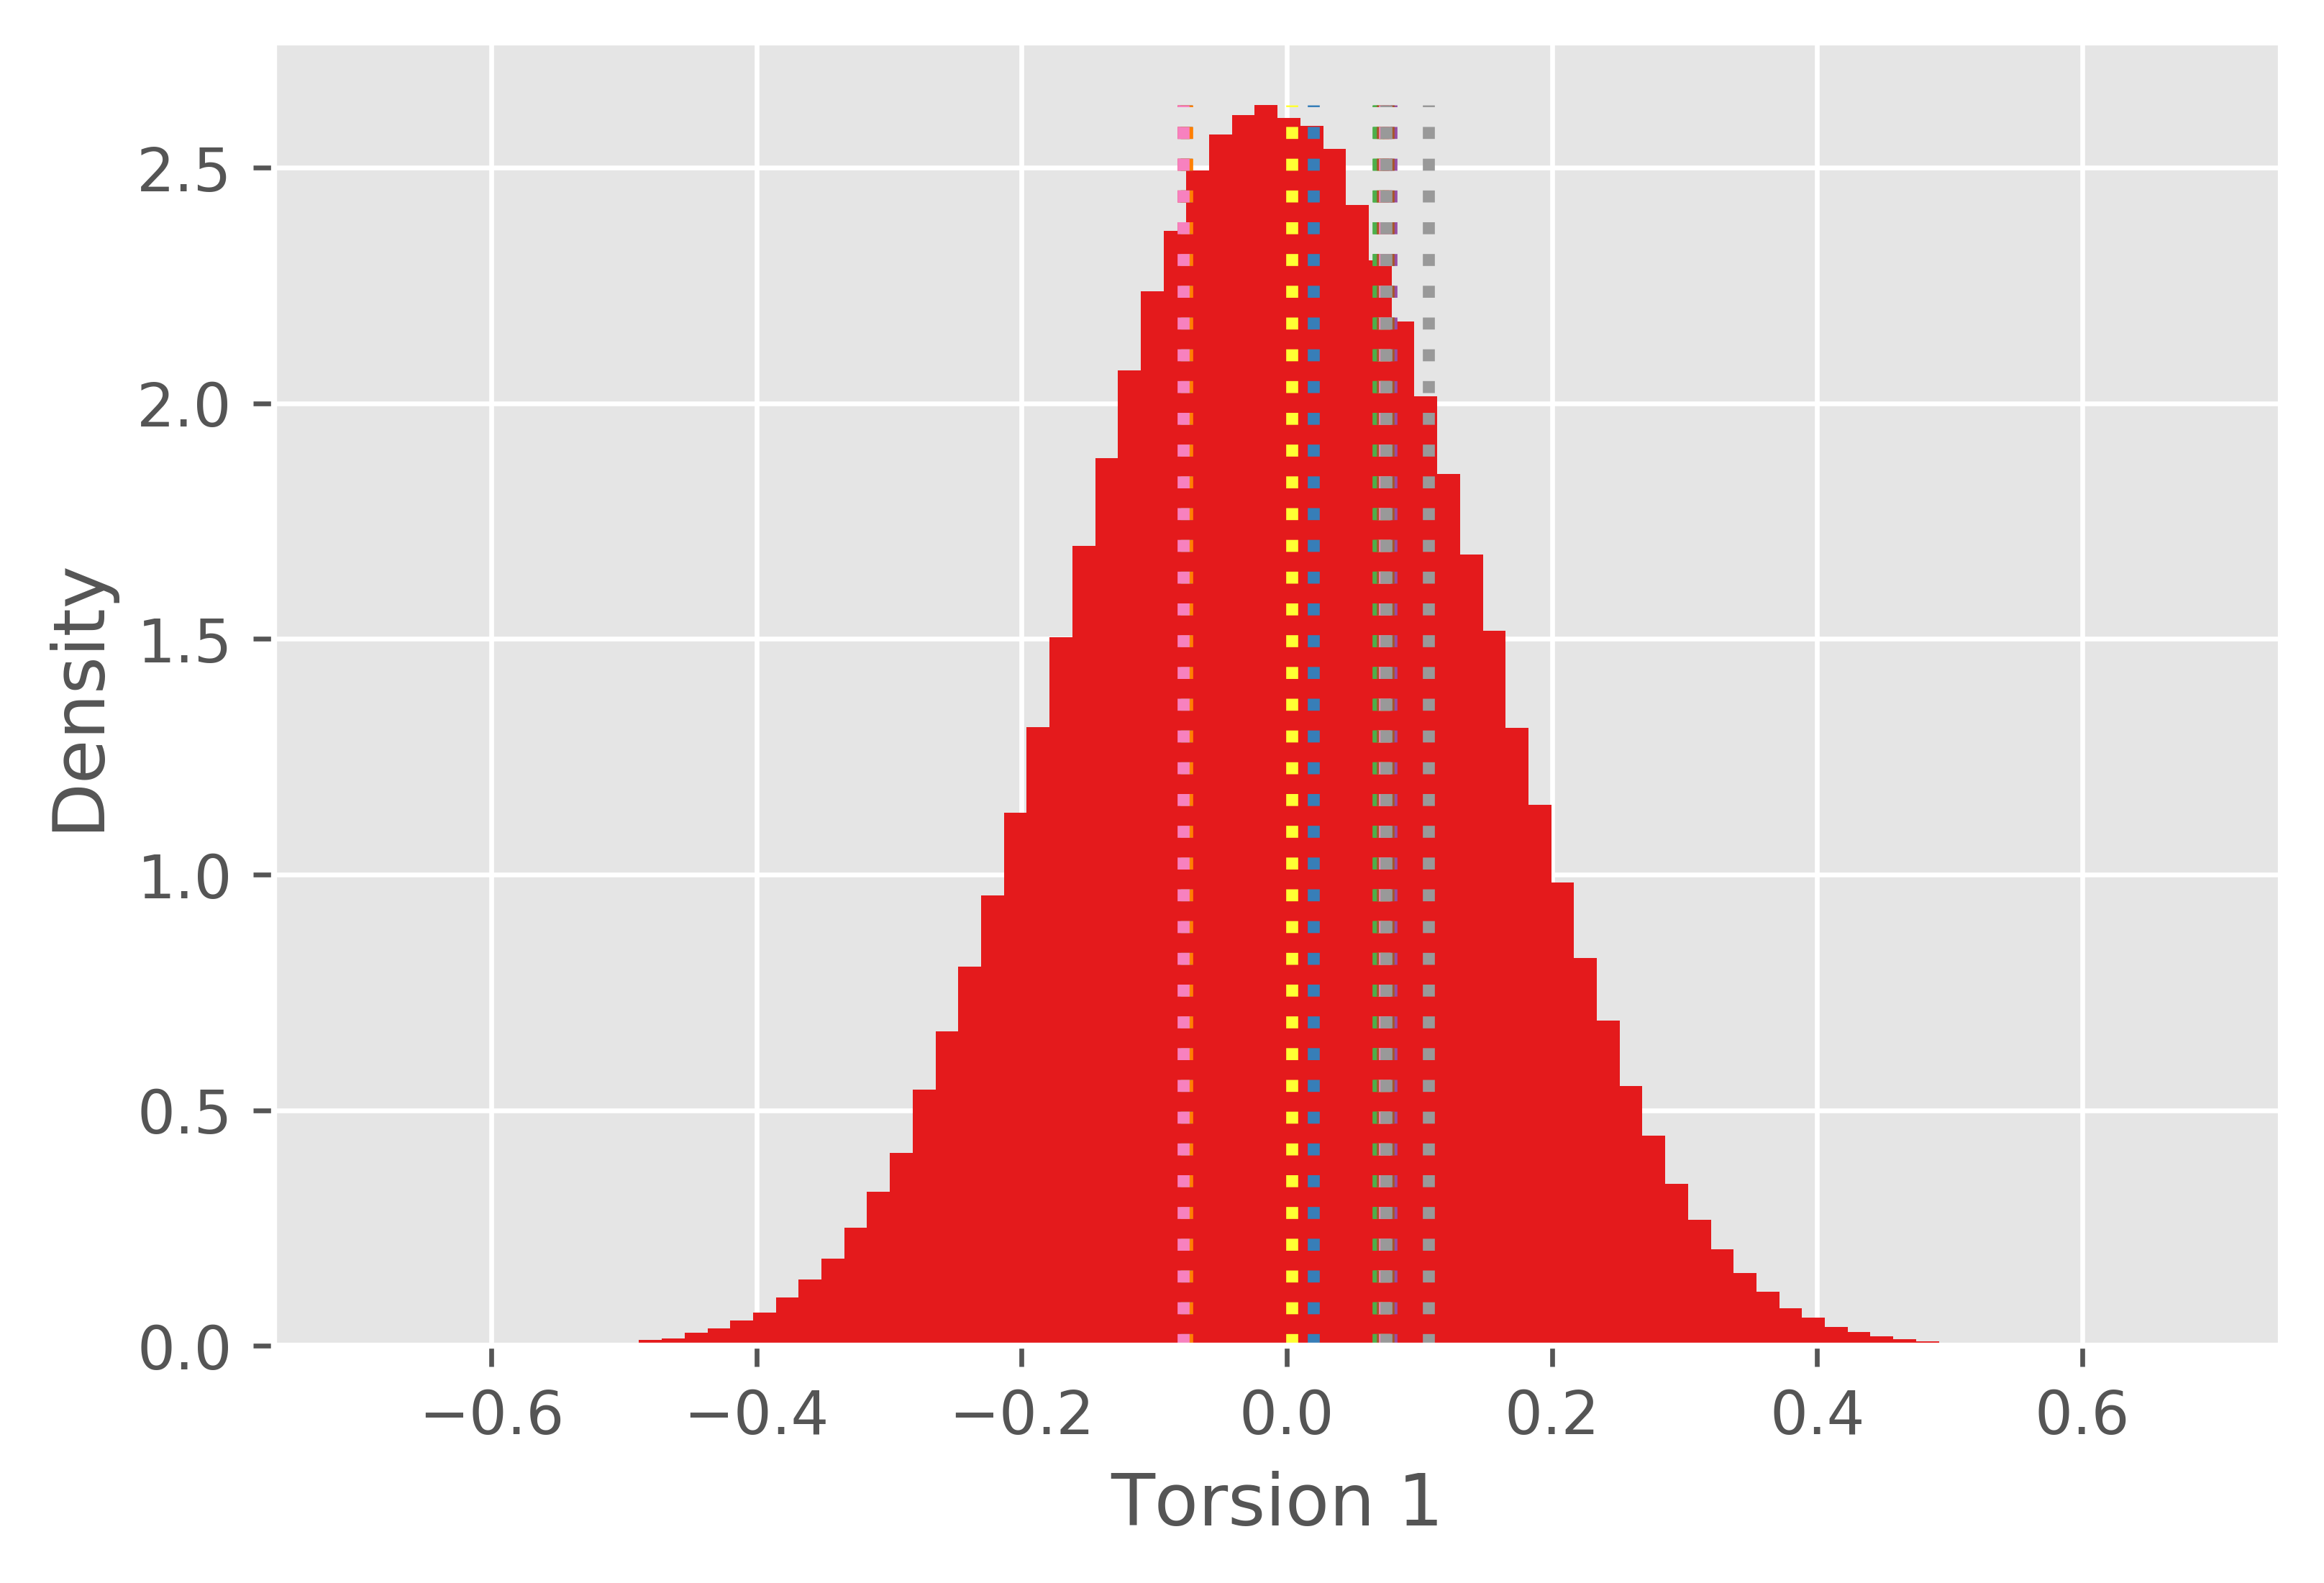

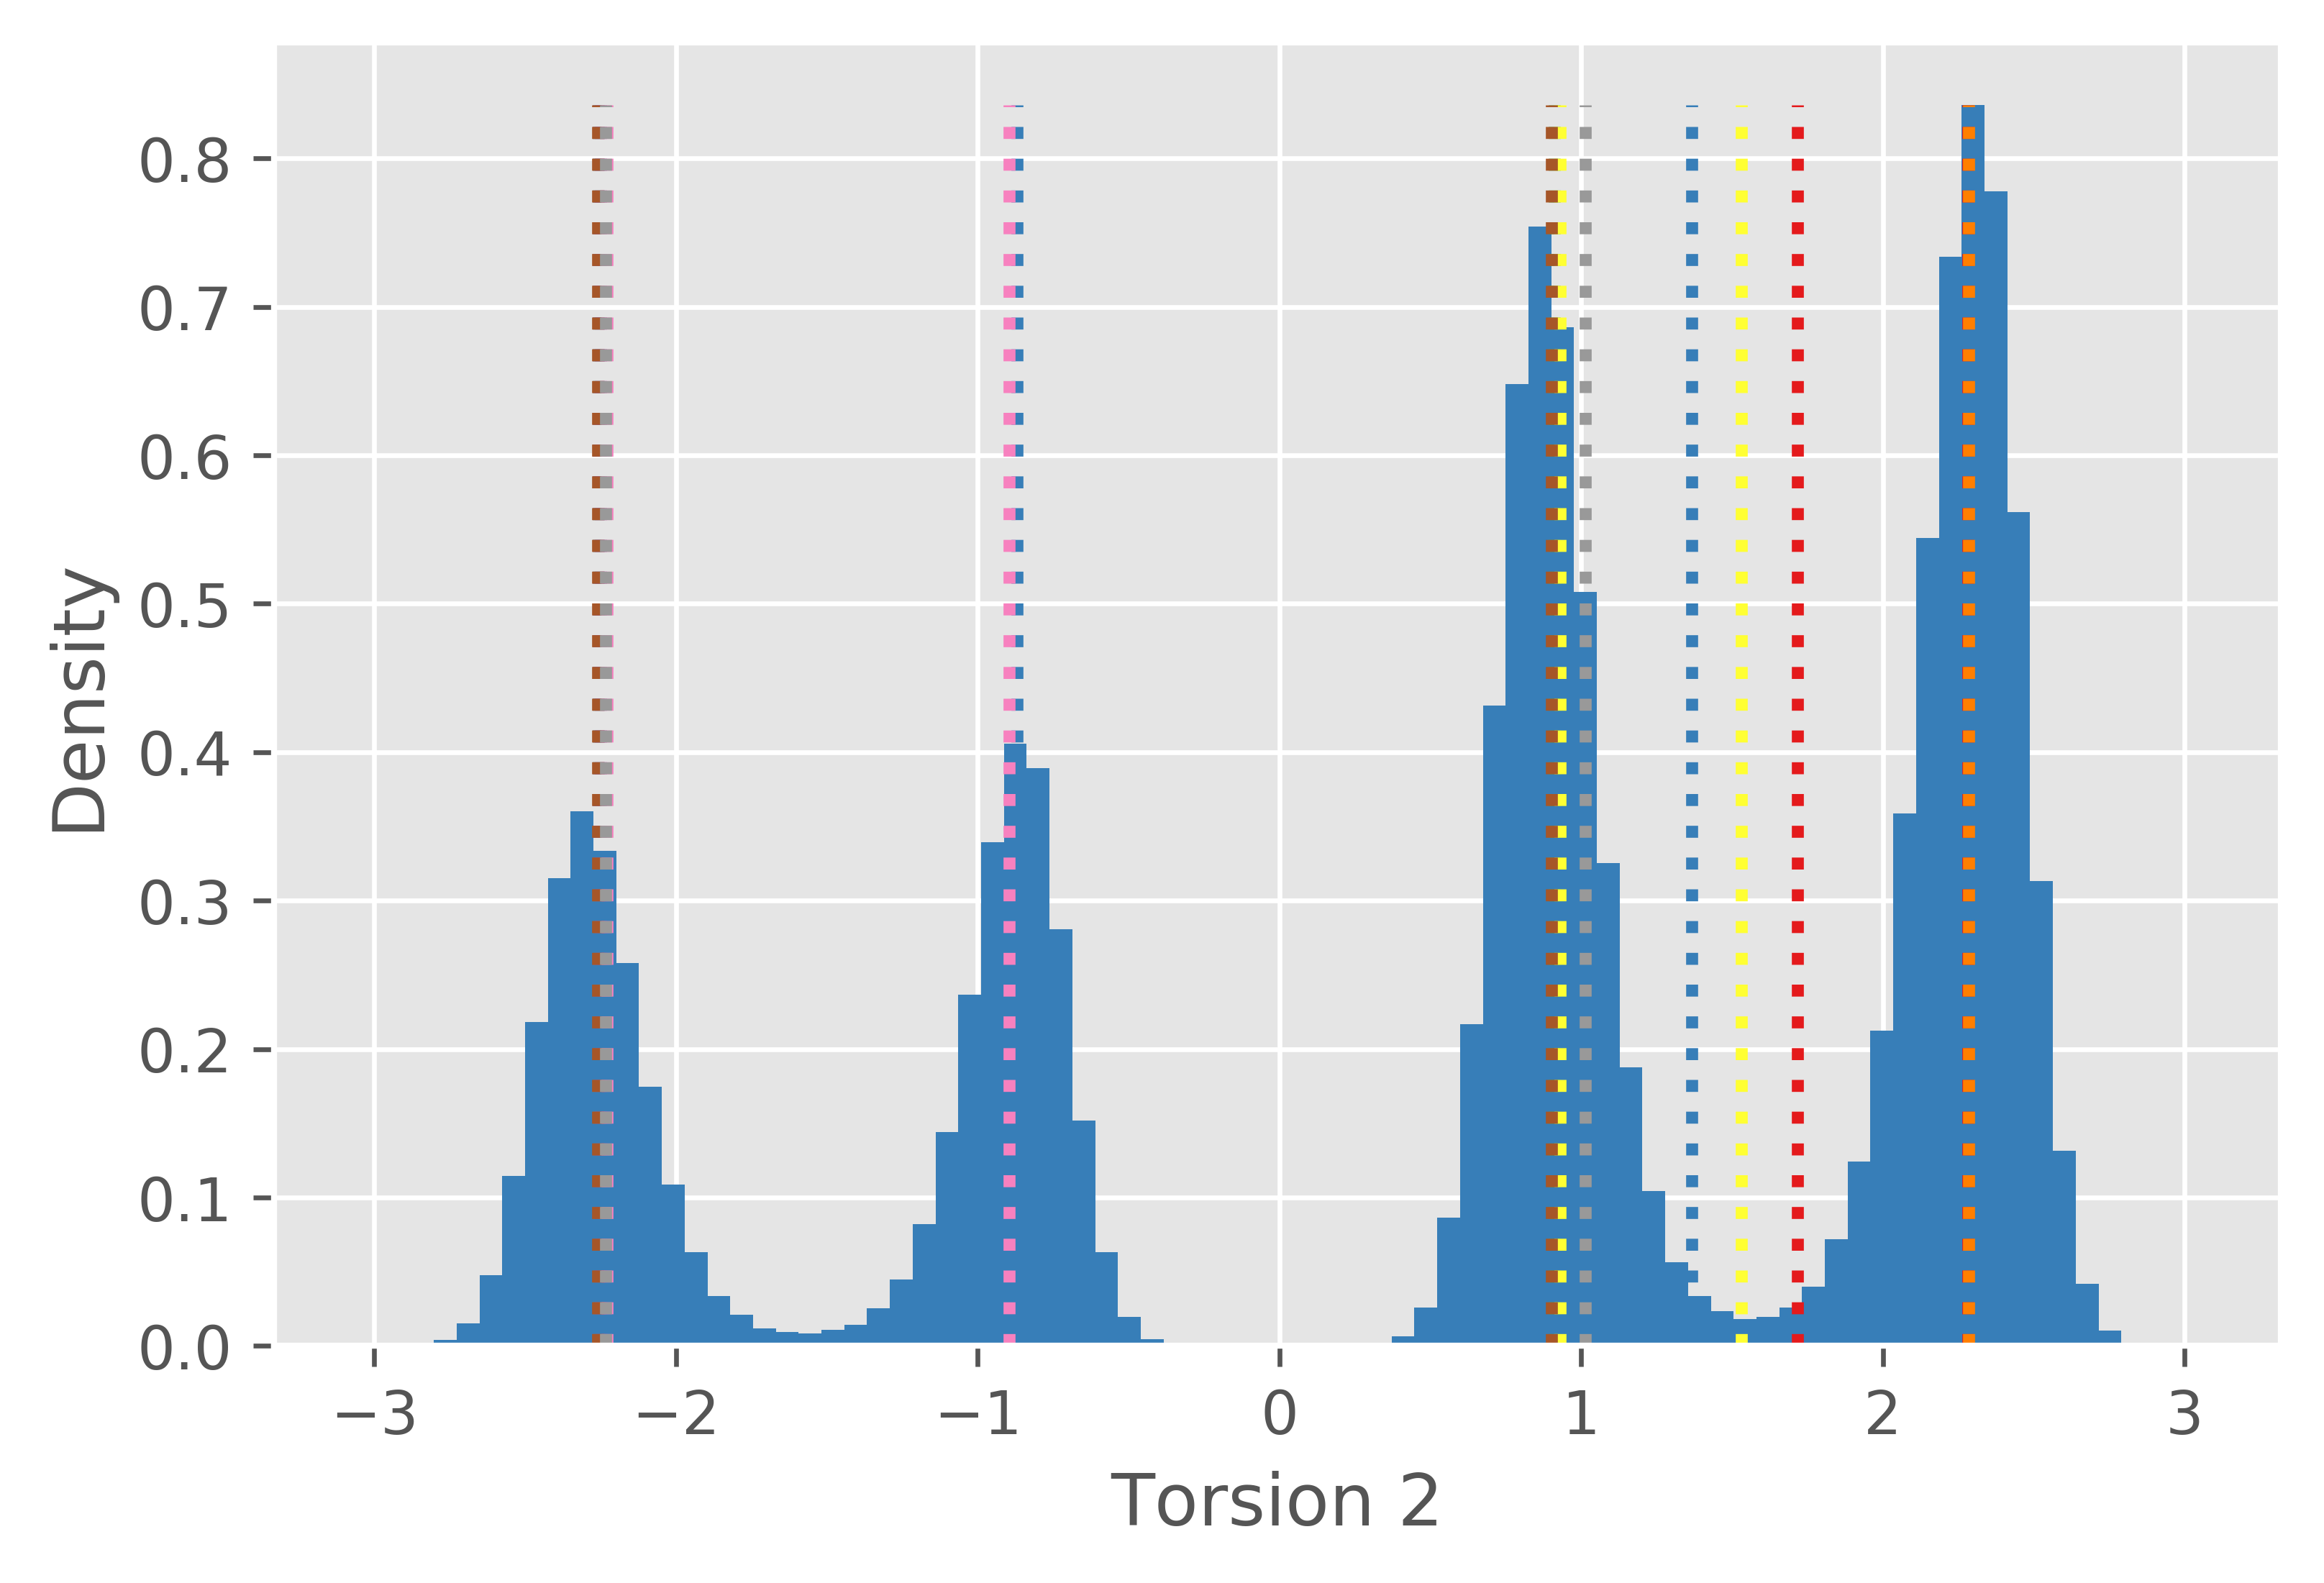

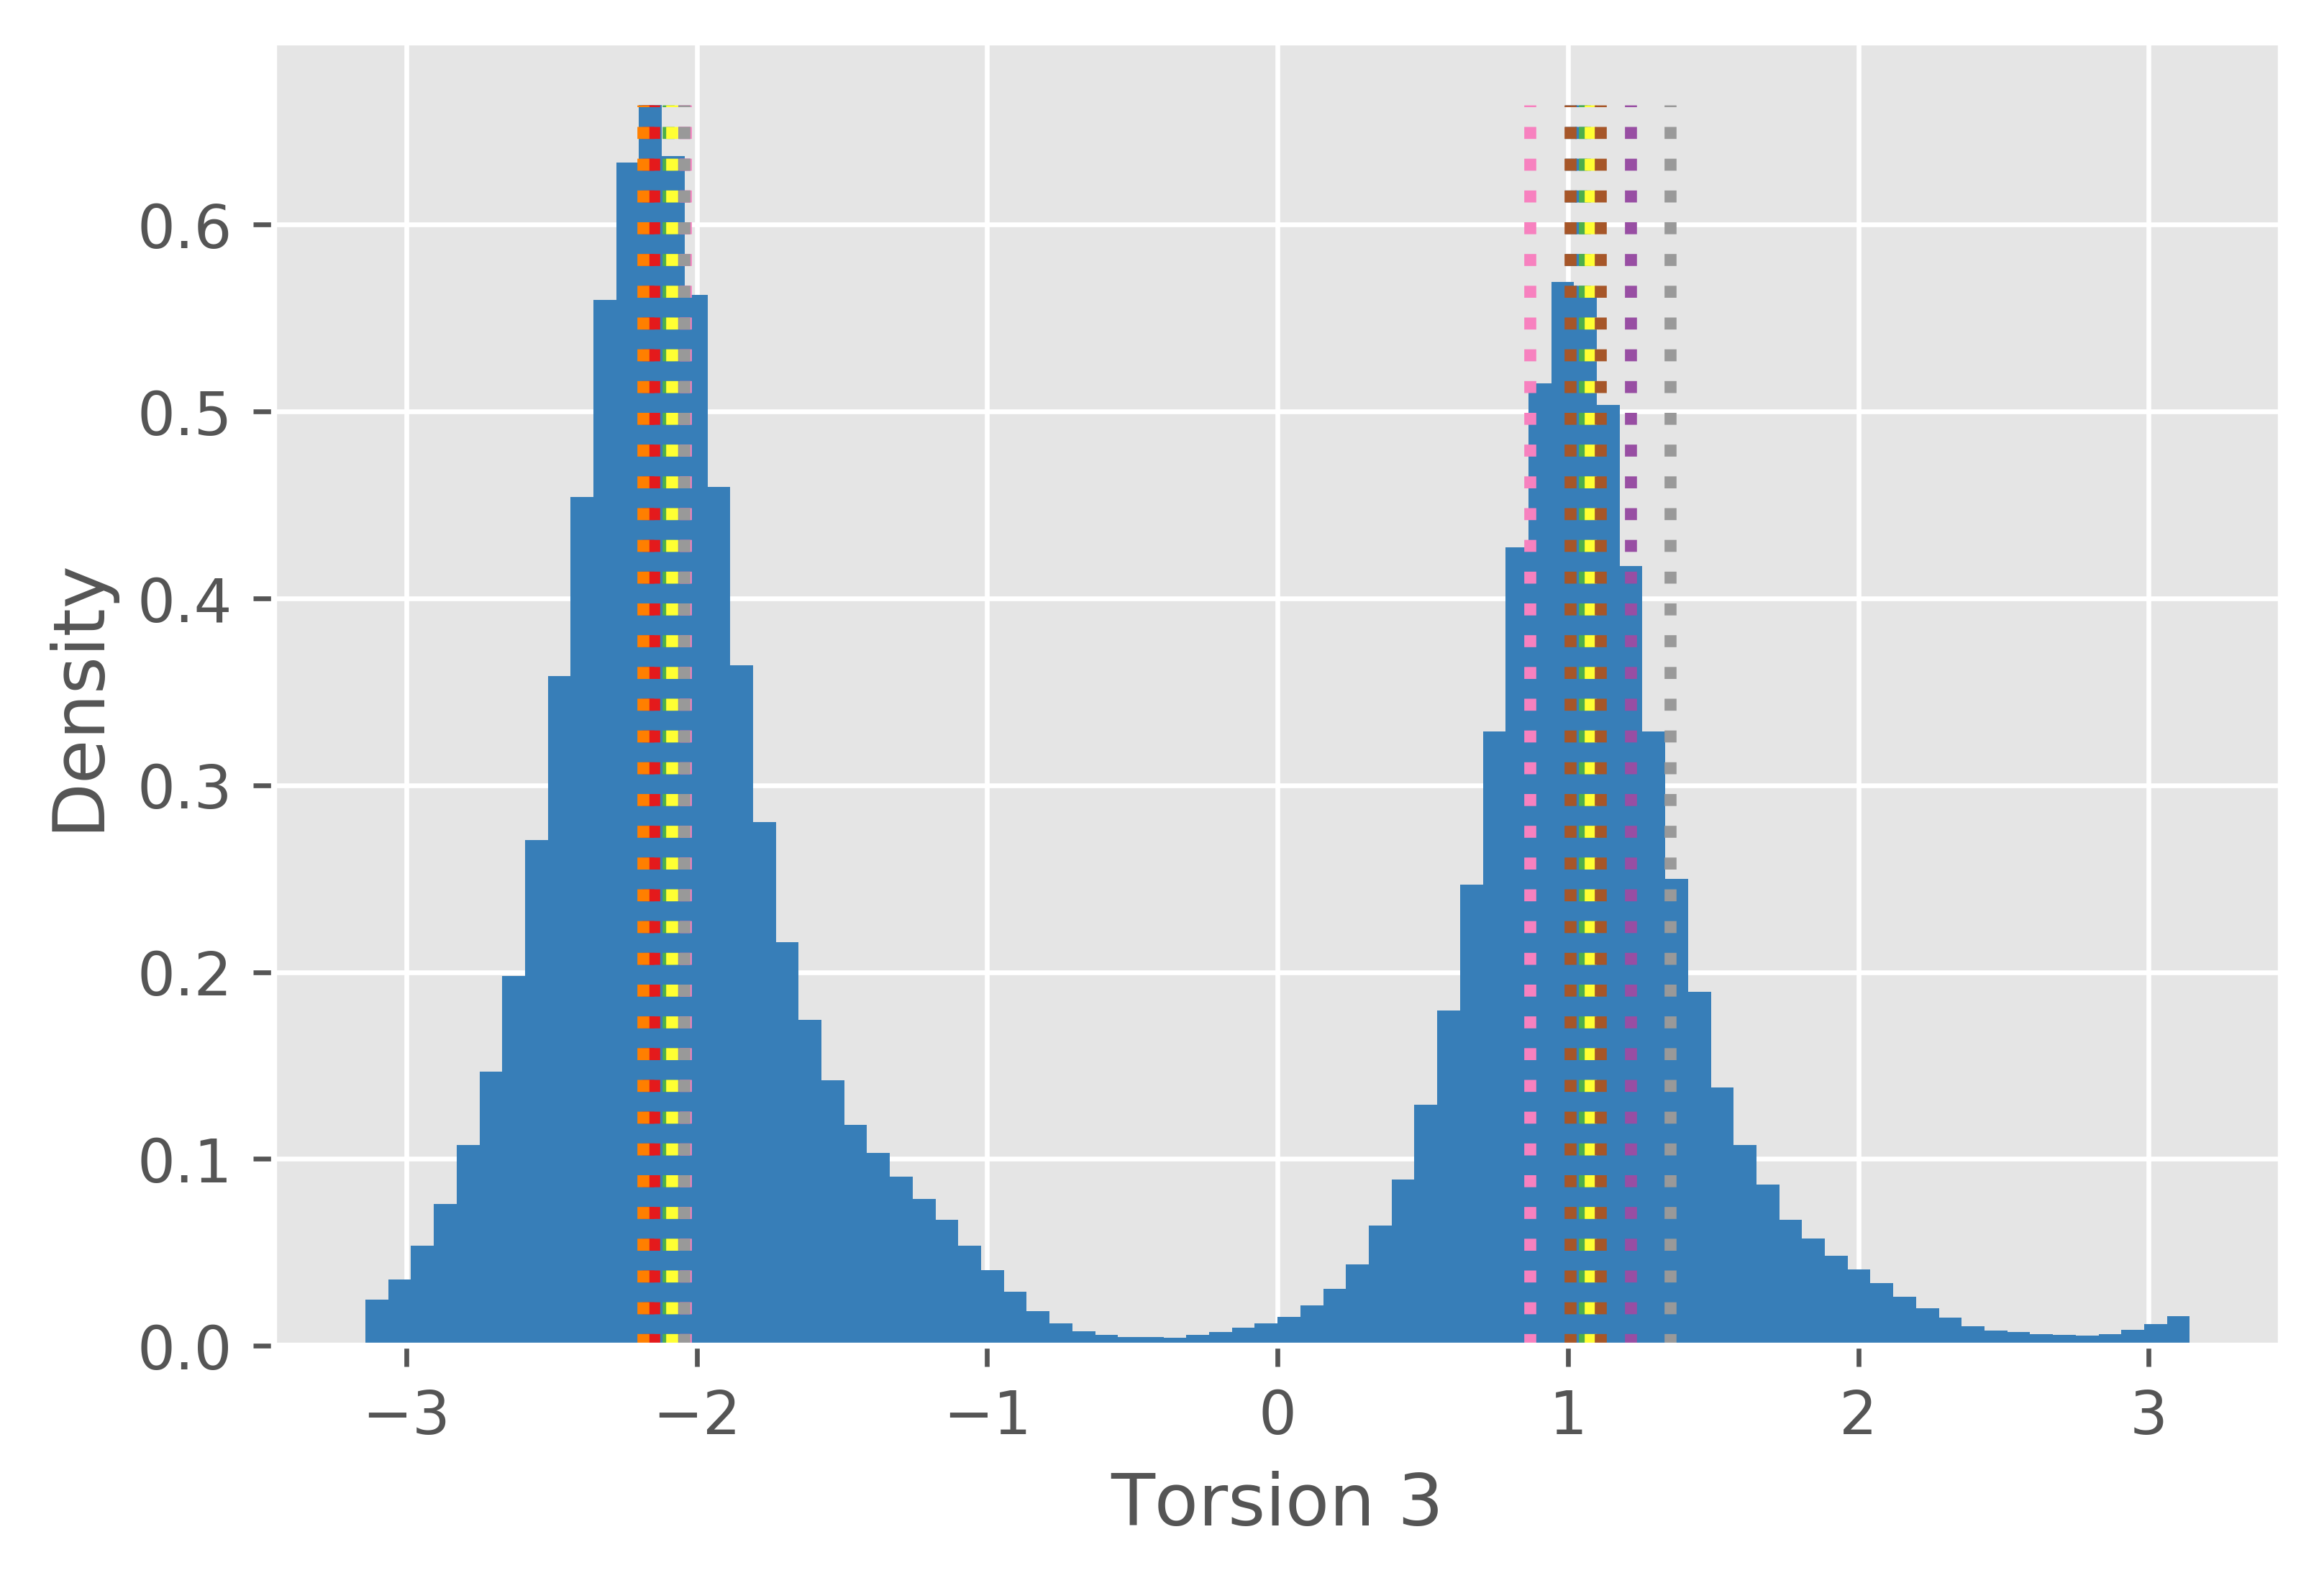

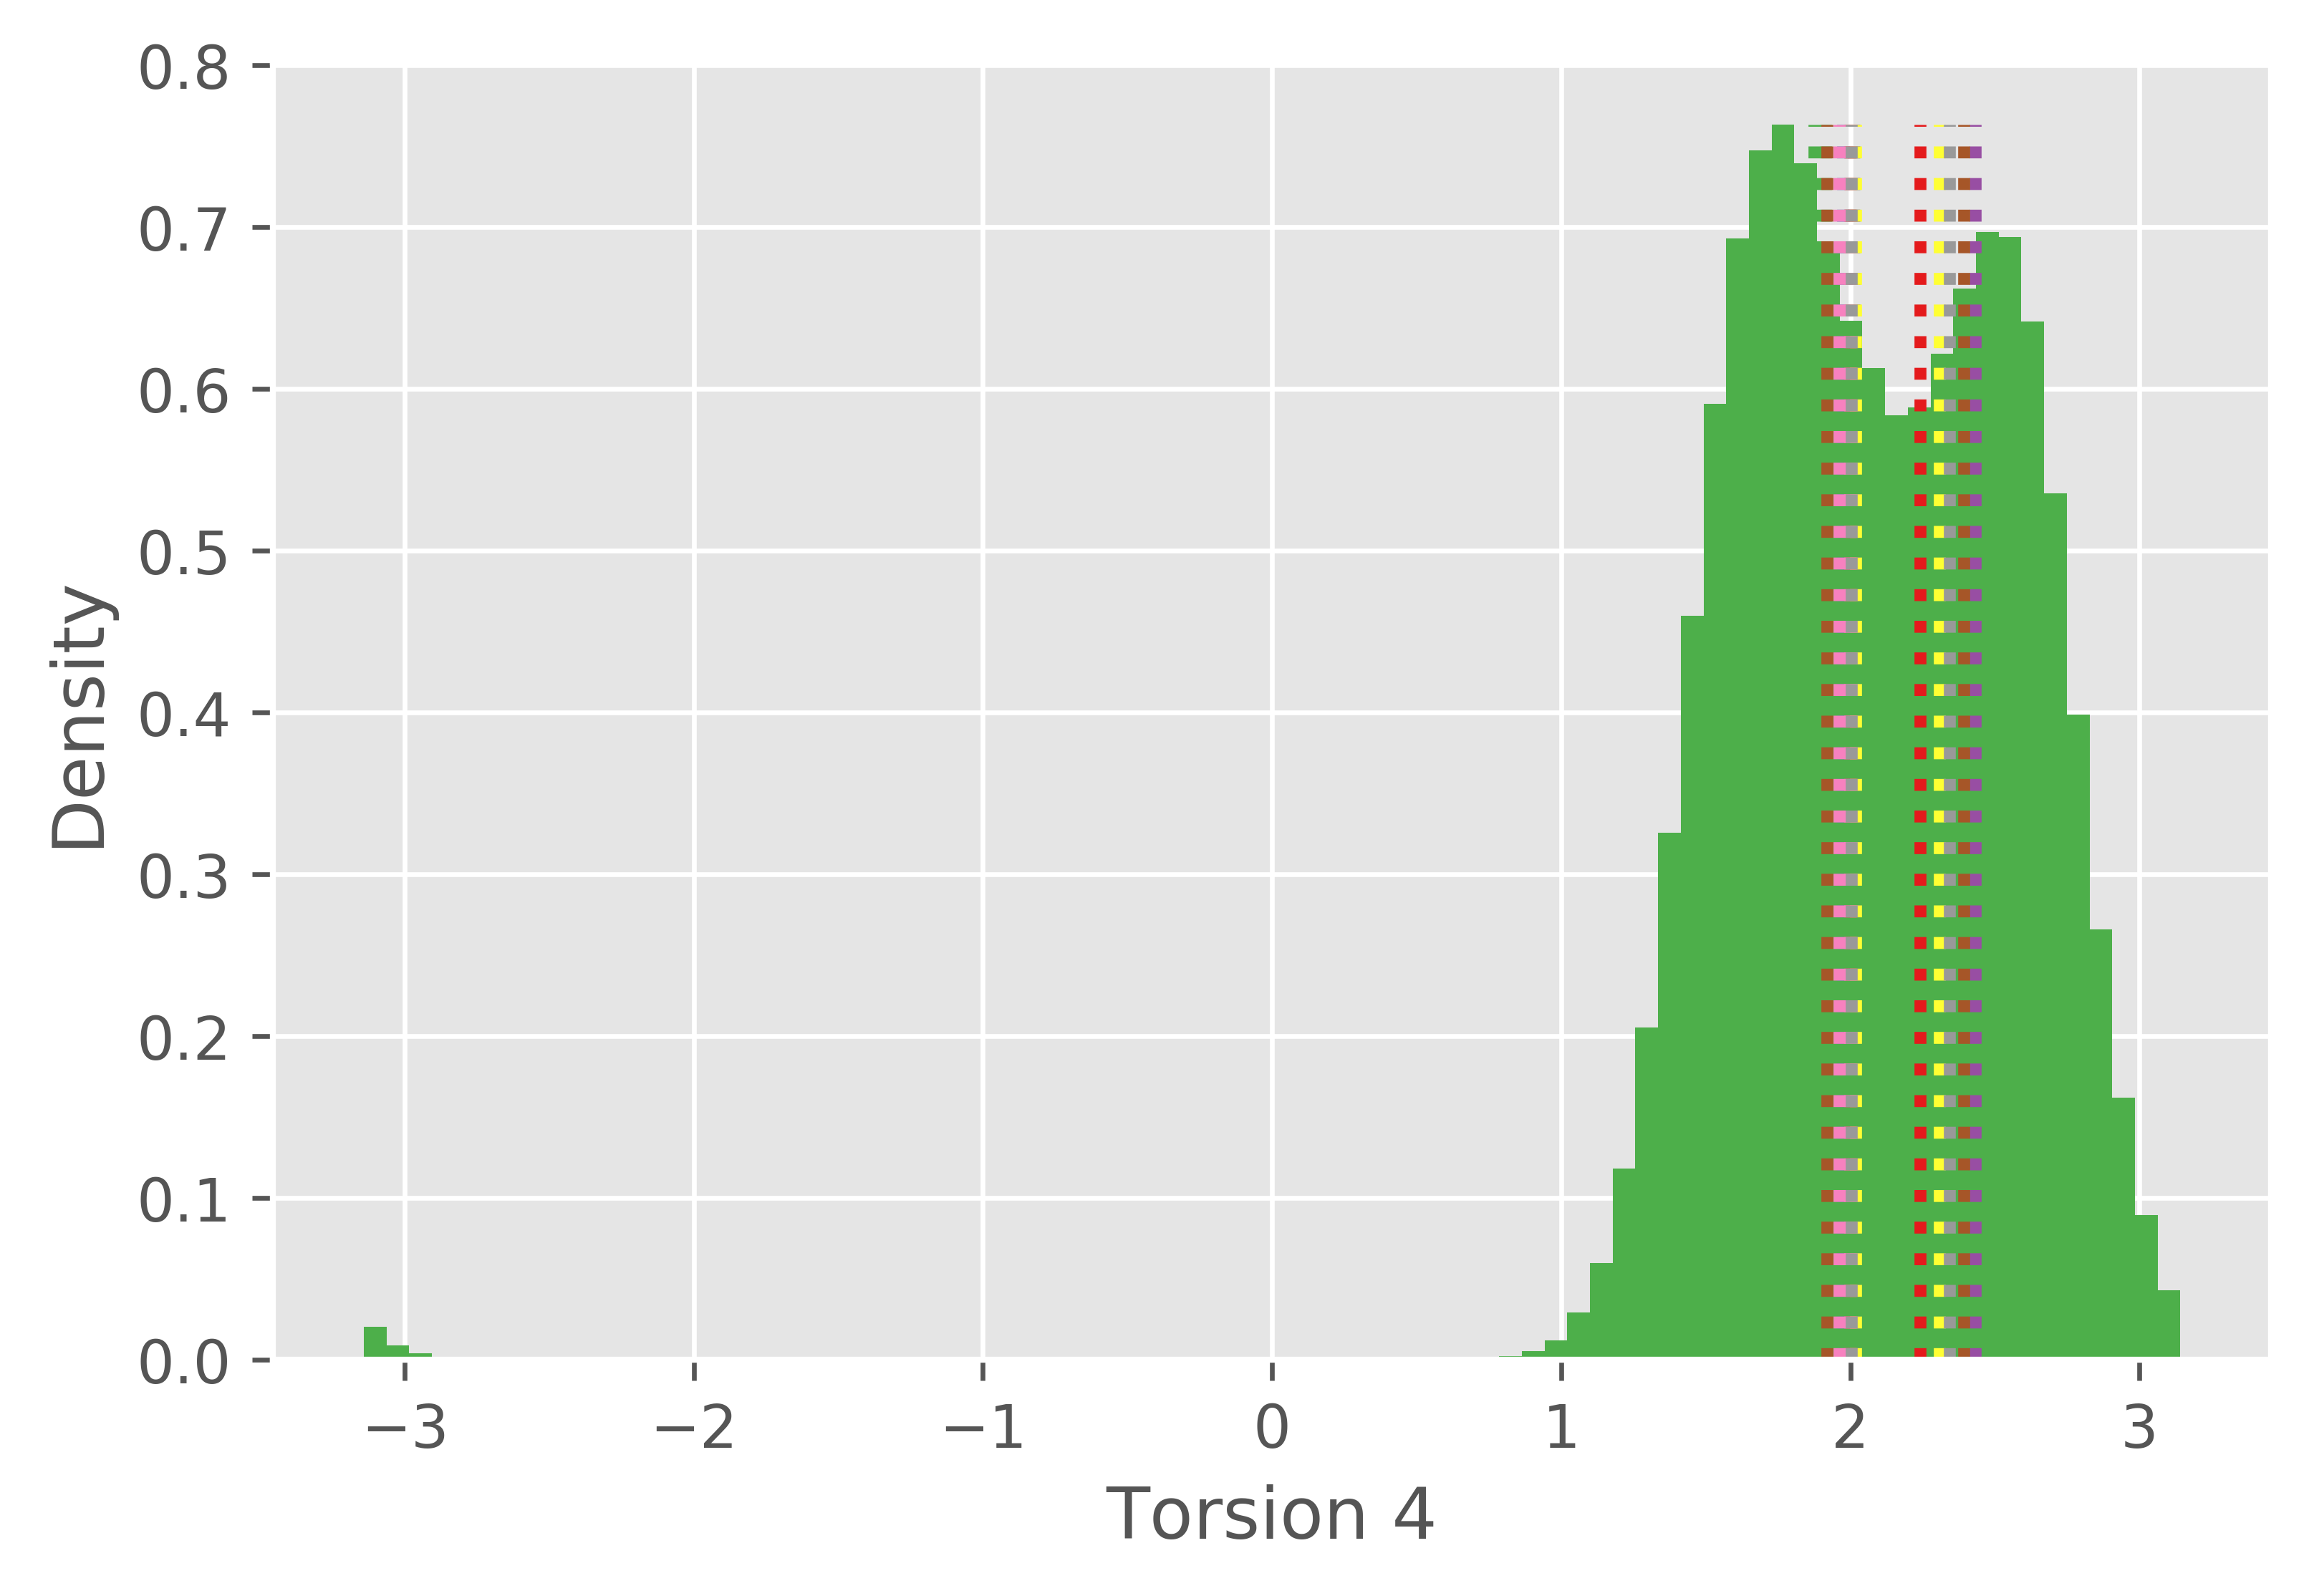

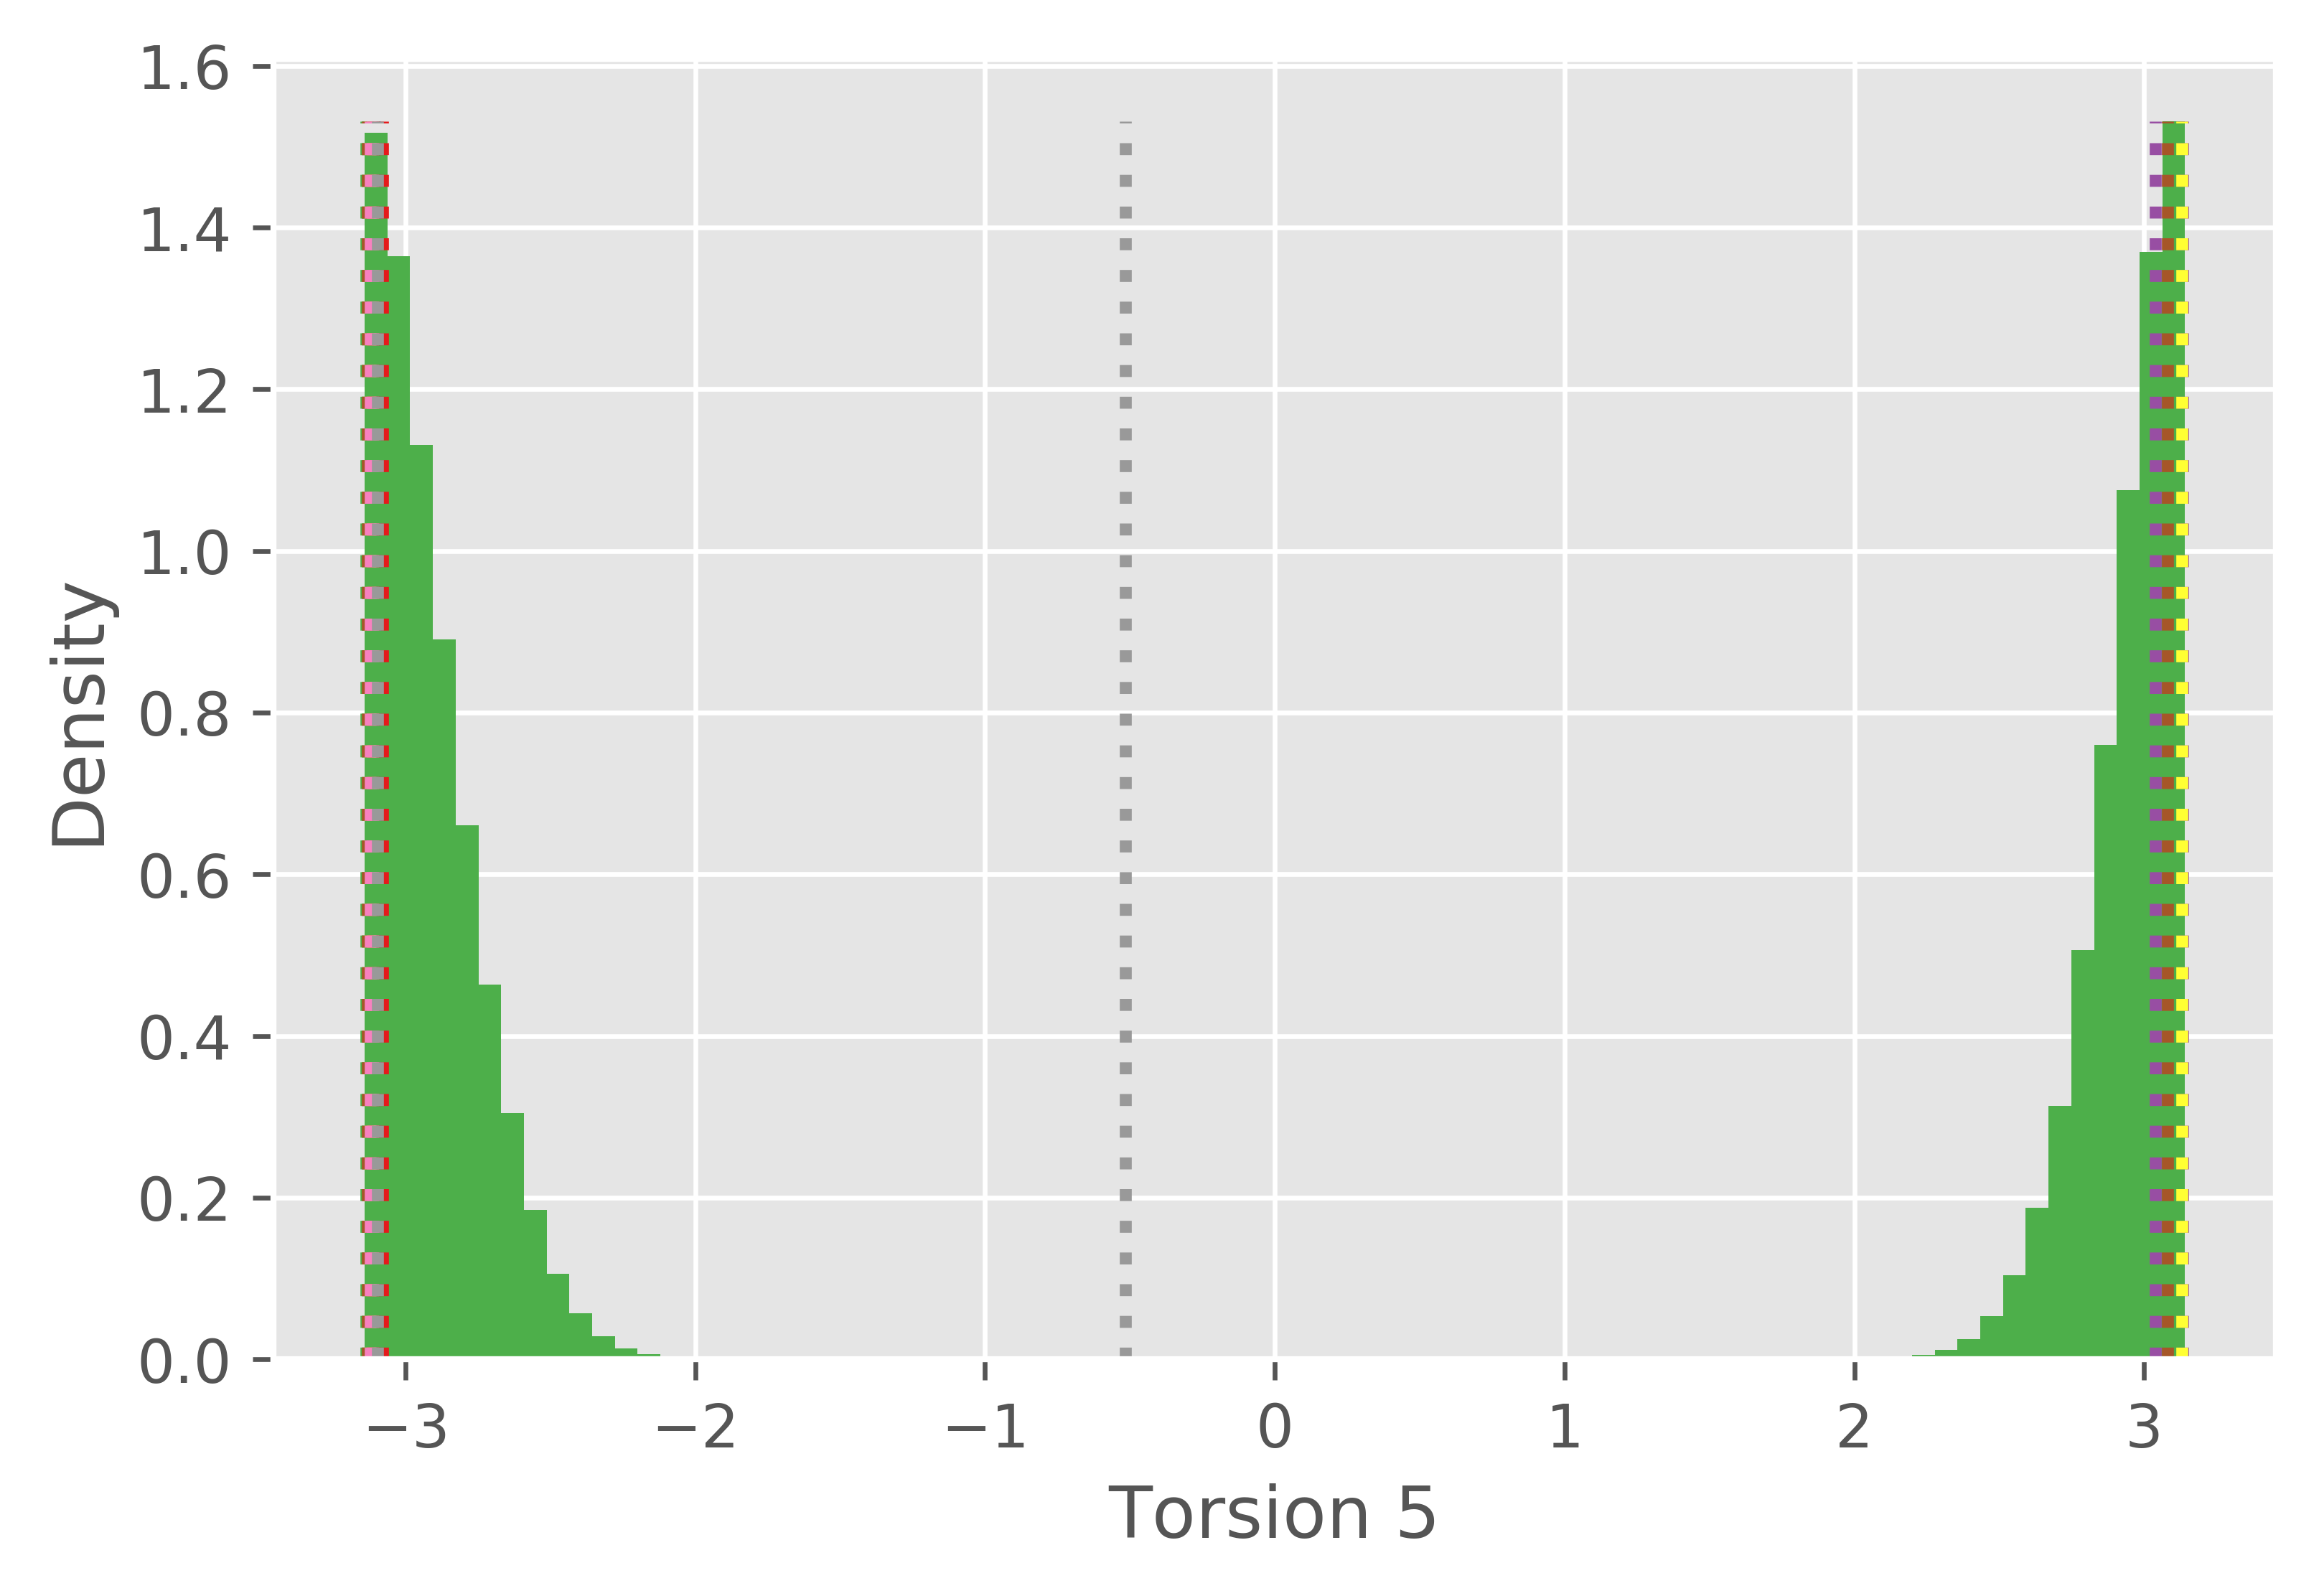

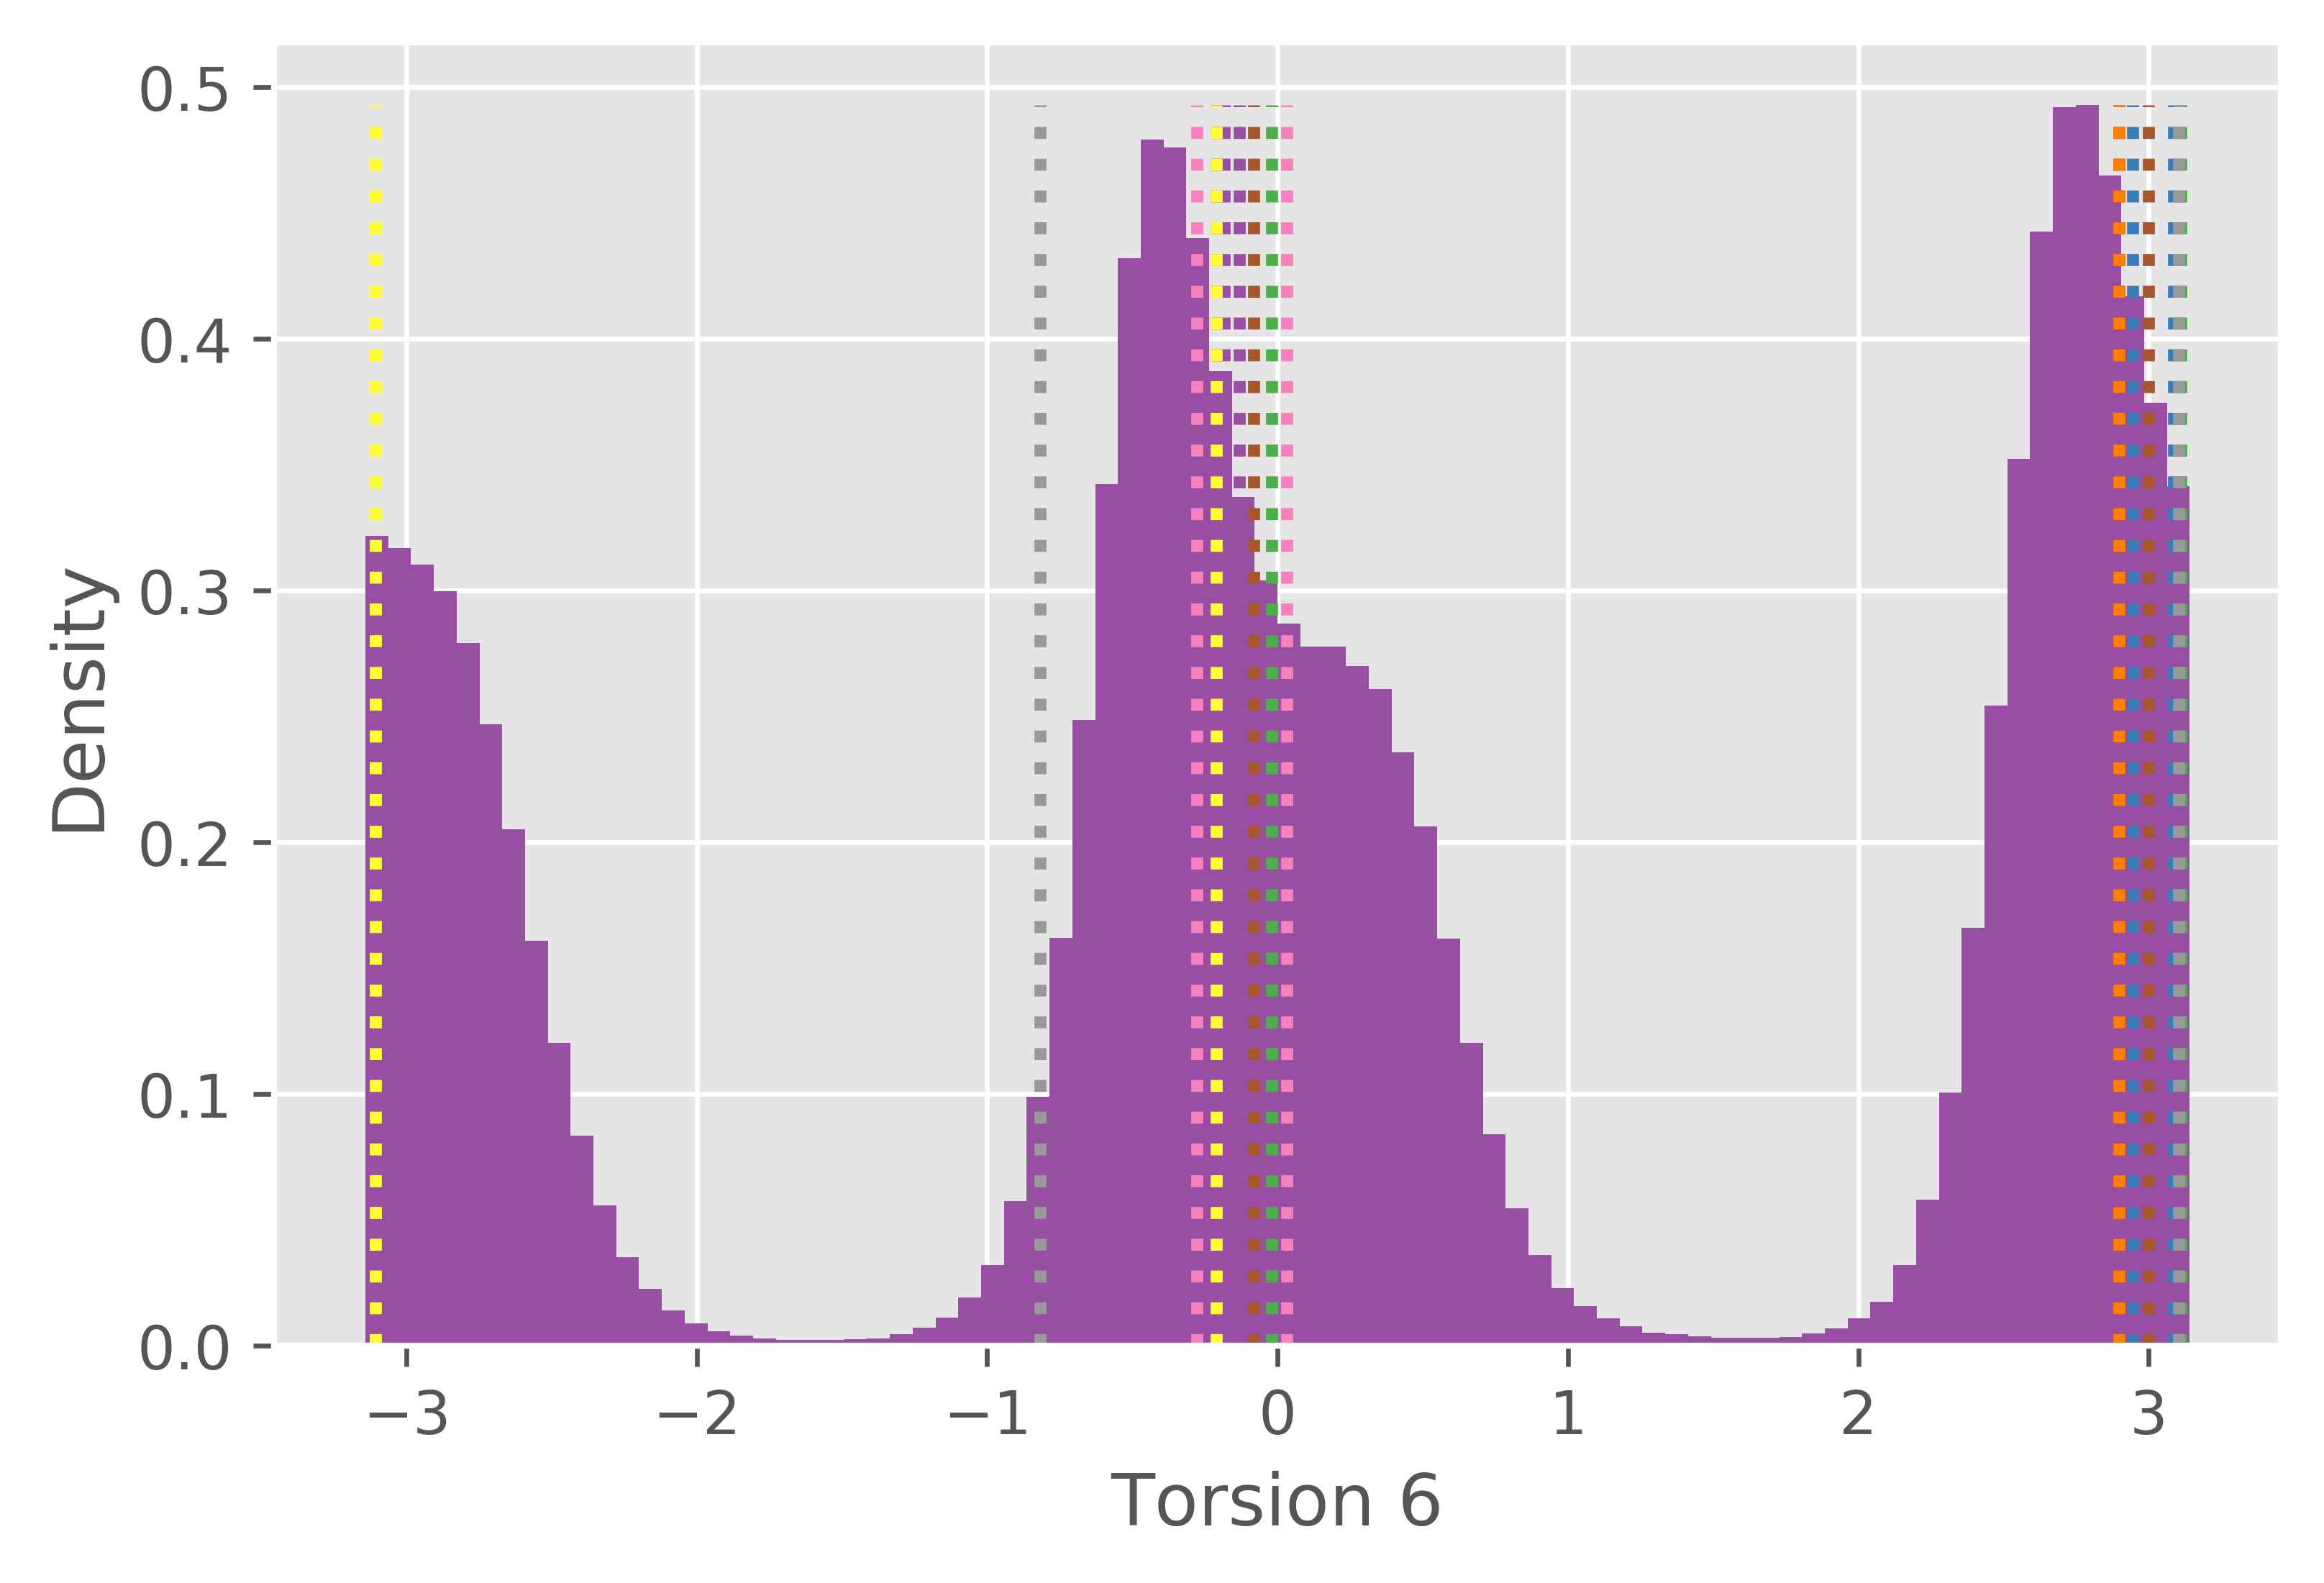

In [47]:
import matplotlib
cm = matplotlib.cm.cmap_d["Set1"]

cluster_id = 0
colors = cm(np.linspace(0,1,7))
for i in range(7):
    plt.figure(dpi=600)
    hist = plt.hist(np.arctan2(per_monomer_torsions_comp[2*i + 1,:], per_monomer_torsions_comp[2*i,:]), bins=80, density=True, color=colors[i])
    print(colors[i])
    plt.xlabel("Torsion " + str(i))
    plt.ylabel("Density")
    plt.savefig("terphenyl_remd_torsion_" + str(i) + ".png")
    colors = cm(np.linspace(0,1,cluster_torsions.shape[1]))
    for j in range(cluster_torsions.shape[1]):
        plt.vlines(cluster_torsions[i,j], ymin=0, ymax=np.max(hist[0]), color = colors[j], linestyles = "dotted", linewidths=2)